# Generación de Modelos con Clusterización - Mes, Codigo Laboralidad

Este notebook va a generar unos ficheros .csv utilizando la generación de modelos por mes y código de laboralidad. 

Dataset Entrenamiento:
- 1) Dividir anual_data en 12 datasets --> mensual_data(1...12) // 12 meses en 1 año
- 2) Particionar mensual_data por segmento --> mensual_data_seg(1...N) // N es el numero total de segmentos
- 3) Particionar por dias con mismo código de lab --> 


Esquema .csv resultado: ID_SEGMENT | Mes | Cod | HH:MM:SS | REF_ARIMA .... X (Model)

### Lectura de datos

In [1]:
import findspark
import pandas as pd
findspark.init()
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext()
sqlContext = SQLContext(sc)
data_input = sqlContext.read.format("com.databricks.spark.csv").options( header = True, inferSchema = True, sep=';',  line_terminator='\n').load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\input.csv')
anual_data = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\anual_data_2018.csv')

In [2]:
anual_data.printSchema()

root
 |-- ID_SEGMENT: integer (nullable = true)
 |-- COD_LABORALIDAD: integer (nullable = true)
 |-- FECHA: timestamp (nullable = true)
 |-- MES: integer (nullable = true)
 |-- HORA: integer (nullable = true)
 |-- MINUTO: integer (nullable = true)
 |-- CANTIDAD_PREC: double (nullable = true)
 |-- TOTAL_VEHICULOS: integer (nullable = true)
 |-- TOTAL_VEHICULOS_1: integer (nullable = true)
 |-- TOTAL_VEHICULOS_2: integer (nullable = true)
 |-- TOTAL_VEHICULOS_3: integer (nullable = true)
 |-- TOTAL_VEHICULOS_4: integer (nullable = true)
 |-- TOTAL_VEHICULOS_5: integer (nullable = true)
 |-- TOTAL_VEHICULOS_6: integer (nullable = true)
 |-- TOTAL_VEHICULOS_7: integer (nullable = true)
 |-- TOTAL_VEHICULOS_8: integer (nullable = true)
 |-- TOTAL_VEHICULOS_9: integer (nullable = true)
 |-- TOTAL_VEHICULOS_10: integer (nullable = true)
 |-- TOTAL_VEHICULOS_11: integer (nullable = true)
 |-- TOTAL_VEHICULOS_12: integer (nullable = true)
 |-- TOTAL_VEHICULOS_13: integer (nullable = true)
 |-- 

In [3]:
anual_data.count()

701045

In [4]:
df_anual_data= anual_data.toPandas()

##### Deal with NaN values

In [5]:
df_anual_data.isnull().any().sum()
df_anual_data = df_anual_data.dropna(how='any')
df_anual_data["TOTAL_VEHICULOS"].fillna(df_anual_data["TOTAL_VEHICULOS"].mean(),inplace=True)

In [6]:
df_anual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691900 entries, 0 to 701044
Data columns (total 32 columns):
ID_SEGMENT            691900 non-null float64
COD_LABORALIDAD       691900 non-null float64
FECHA                 691900 non-null datetime64[ns]
MES                   691900 non-null float64
HORA                  691900 non-null float64
MINUTO                691900 non-null float64
CANTIDAD_PREC         691900 non-null float64
TOTAL_VEHICULOS       691900 non-null float64
TOTAL_VEHICULOS_1     691900 non-null float64
TOTAL_VEHICULOS_2     691900 non-null float64
TOTAL_VEHICULOS_3     691900 non-null float64
TOTAL_VEHICULOS_4     691900 non-null float64
TOTAL_VEHICULOS_5     691900 non-null float64
TOTAL_VEHICULOS_6     691900 non-null float64
TOTAL_VEHICULOS_7     691900 non-null float64
TOTAL_VEHICULOS_8     691900 non-null float64
TOTAL_VEHICULOS_9     691900 non-null float64
TOTAL_VEHICULOS_10    691900 non-null float64
TOTAL_VEHICULOS_11    691900 non-null float64
TOTAL_VE

In [7]:
from datetime import datetime, timedelta 
df_anual_data.index = pd.to_datetime(df_anual_data['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))
df_anual_data.index[:5]

Index(['00:00:00', '00:00:00', '00:00:00', '00:00:00', '00:00:00'], dtype='object', name='FECHA')

### Lectura de Dataset de testing

In [9]:
enero19 = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\enero19.csv')
febrero19 = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\febrero19.csv')
df_enero19 = enero19.toPandas()
df_febrero19 = febrero19.toPandas()

##### Deal with NaN values

In [10]:
df_enero19.isnull().any().sum()
df_febrero19.isnull().any().sum()
df_febrero19 = df_febrero19.dropna(how='any')
df_enero19 = df_enero19.dropna(how='any')
df_enero19["TOTAL_VEHICULOS"].fillna(df_enero19["TOTAL_VEHICULOS"].mean(),inplace=True)
df_febrero19["TOTAL_VEHICULOS"].fillna(df_febrero19["TOTAL_VEHICULOS"].mean(),inplace=True)

df_enero19.index = pd.to_datetime(df_enero19['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))
df_febrero19.index = pd.to_datetime(df_febrero19['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))

In [11]:
df_enero19.info()
df_febrero19.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58830 entries, 00:00:00 to 00:00:00
Data columns (total 32 columns):
ID_SEGMENT            58830 non-null float64
COD_LABORALIDAD       58830 non-null float64
FECHA                 58830 non-null datetime64[ns]
MES                   58830 non-null float64
HORA                  58830 non-null float64
MINUTO                58830 non-null float64
CANTIDAD_PREC         58830 non-null float64
TOTAL_VEHICULOS       58830 non-null float64
TOTAL_VEHICULOS_1     58830 non-null float64
TOTAL_VEHICULOS_2     58830 non-null float64
TOTAL_VEHICULOS_3     58830 non-null float64
TOTAL_VEHICULOS_4     58830 non-null float64
TOTAL_VEHICULOS_5     58830 non-null float64
TOTAL_VEHICULOS_6     58830 non-null float64
TOTAL_VEHICULOS_7     58830 non-null float64
TOTAL_VEHICULOS_8     58830 non-null float64
TOTAL_VEHICULOS_9     58830 non-null float64
TOTAL_VEHICULOS_10    58830 non-null float64
TOTAL_VEHICULOS_11    58830 non-null float64
TOTAL_VEHICULOS_12    58

### Generate Training Datasets

In [12]:
months = df_anual_data.FECHA.dt.month.unique()
segments = df_anual_data.ID_SEGMENT.unique()
codes = df_anual_data.COD_LABORALIDAD.unique()

print("Months " + str(months))
print("Segments " + str(segments))
print("Codes " + str(codes))

total_trainsets = len(months) * len(segments) * len(codes)
print("Number of training sets: " + str(total_trainsets))

Months [ 1  2  3  4  5  6  7  8  9 10 11 12]
Segments [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Codes [2. 1. 3. 4. 5. 6. 7.]
Number of training sets: 1680


In [15]:
rows_per_day=int(((60/15)*24))

training_sets = {'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD':[], 'TRAINING_SET':[] }
for seg_id in segments: # 1) Particionar anual_data por segmento
    df_seg = df_anual_data.loc[df_anual_data.ID_SEGMENT==seg_id]
    for month_i in df_seg.FECHA.dt.month.unique(): # 2) Dividir mensual_data en 12 datasets 
        df_month_seg = df_seg.loc[df_seg.FECHA.dt.month==month_i]
        for code_i in df_month_seg.COD_LABORALIDAD.unique(): # 3) Particionar por dias con mismo código de lab
            df_month_seg_code = df_month_seg.loc[df_month_seg.COD_LABORALIDAD==code_i]
                
            # Fill training_sets dictionary
            training_sets['ID_SEGMENT'].append(seg_id)
            training_sets['MES'].append(month_i)
            training_sets['COD_LABORALIDAD'].append(code_i)
            training_sets['TRAINING_SET'].append(df_month_seg_code)

In [16]:
for row in range(0,total_trainsets):
    print("----------------------------> TRAINING SET NUMBER: " + str(row))
    print("SEGMENTO " + str(training_sets['ID_SEGMENT'][row]))
    print("MES " + str(training_sets['MES'][row]))
    print("COD_LABORALIDAD " + str(training_sets['COD_LABORALIDAD'][row]))
    print("DAYS IN TRAINING_SET: " + str(training_sets['TRAINING_SET'][row].FECHA.dt.day.unique()))

----------------------------> TRAINING SET NUMBER: 0
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 1
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [28  7 14 21]
----------------------------> TRAINING SET NUMBER: 2
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [30  2  9 16 23  1]
----------------------------> TRAINING SET NUMBER: 3
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [31  3 10 17 24]
----------------------------> TRAINING SET NUMBER: 4
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 5
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 6
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 7
SEGMENTO 1.0
MES 2
COD_LABORALIDAD 5.0


DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 117
SEGMENTO 2.0
MES 5
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 9 16 23 30  2]
----------------------------> TRAINING SET NUMBER: 118
SEGMENTO 2.0
MES 5
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [10 17 24 31  3]
----------------------------> TRAINING SET NUMBER: 119
SEGMENTO 2.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 120
SEGMENTO 2.0
MES 6
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 121
SEGMENTO 2.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 122
SEGMENTO 2.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 123
SEGMENTO 2.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET

----------------------------> TRAINING SET NUMBER: 231
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 232
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 233
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 234
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 235
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 236
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 237
SEGMENTO 3.0
MES 10
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 238
SEGMENTO 3.0
MES 11

MES 4
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 361
SEGMENTO 5.0
MES 4
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 362
SEGMENTO 5.0
MES 4
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 363
SEGMENTO 5.0
MES 4
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 364
SEGMENTO 5.0
MES 5
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 365
SEGMENTO 5.0
MES 5
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 366
SEGMENTO 5.0
MES 5
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 367
SEGMENTO 5.0
MES 5
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
-------------------------

DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 475
SEGMENTO 6.0
MES 8
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 476
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 477
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 478
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 479
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 480
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 481
SEGMENTO 6.0
MES 9
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBE

DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 600
SEGMENTO 8.0
MES 2
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 601
SEGMENTO 8.0
MES 2
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 602
SEGMENTO 8.0
MES 3
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 603
SEGMENTO 8.0
MES 3
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 604
SEGMENTO 8.0
MES 3
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 605
SEGMENTO 8.0
MES 3
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 606
SEGMENTO 8.0
MES 3
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NU

COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 729
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 730
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 731
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 732
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 733
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 734
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 735
SEGMENTO 9.0
MES 10
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
------------------------

DAYS IN TRAINING_SET: [30  2  9 16 23  1]
----------------------------> TRAINING SET NUMBER: 843
SEGMENTO 11.0
MES 1
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [31  3 10 17 24]
----------------------------> TRAINING SET NUMBER: 844
SEGMENTO 11.0
MES 1
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 845
SEGMENTO 11.0
MES 1
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 846
SEGMENTO 11.0
MES 1
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 847
SEGMENTO 11.0
MES 2
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 1  8 15 22]
----------------------------> TRAINING SET NUMBER: 848
SEGMENTO 11.0
MES 2
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 23]
----------------------------> TRAINING SET NUMBER: 849
SEGMENTO 11.0
MES 2
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING

DAYS IN TRAINING_SET: [ 9 16 23 30  2]
----------------------------> TRAINING SET NUMBER: 958
SEGMENTO 12.0
MES 5
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [10 17 24 31  3]
----------------------------> TRAINING SET NUMBER: 959
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 960
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 961
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 962
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 963
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET NUMBER: 964
SEGMENTO 12.0
MES 6
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------> TRAIN

DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 1081
SEGMENTO 13.0
MES 11
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1082
SEGMENTO 13.0
MES 11
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1083
SEGMENTO 13.0
MES 11
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1084
SEGMENTO 13.0
MES 11
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1085
SEGMENTO 13.0
MES 12
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 1086
SEGMENTO 13.0
MES 12
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [30  2  9 16 23]
----------------------------> TRAINING SET NUMBER: 1087
SEGMENTO 13.0
MES 12
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [31  3 10 17 24]
------------------------

----------------------------> TRAINING SET NUMBER: 1205
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1206
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1207
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1208
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1209
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 9 16 23 30  2]
----------------------------> TRAINING SET NUMBER: 1210
SEGMENTO 15.0
MES 5
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [10 17 24 31  3]
----------------------------> TRAINING SET NUMBER: 1211
SEGMENTO 15.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 1212
SEGMENTO 15

----------------------------> TRAINING SET NUMBER: 1331
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 30]
----------------------------> TRAINING SET NUMBER: 1332
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17]
----------------------------> TRAINING SET NUMBER: 1333
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18]
----------------------------> TRAINING SET NUMBER: 1334
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19]
----------------------------> TRAINING SET NUMBER: 1335
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1336
SEGMENTO 16.0
MES 11
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1337
SEGMENTO 16.0
MES 12
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 1338
SEGMENTO 16.0
MES 1

DAYS IN TRAINING_SET: [ 9 16 23 30  2]
----------------------------> TRAINING SET NUMBER: 1462
SEGMENTO 18.0
MES 5
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [10 17 24 31  3]
----------------------------> TRAINING SET NUMBER: 1463
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 1464
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 1465
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 1466
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 1467
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET NUMBER: 1468
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------

DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 1578
SEGMENTO 19.0
MES 10
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1579
SEGMENTO 19.0
MES 10
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1580
SEGMENTO 19.0
MES 10
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1581
SEGMENTO 19.0
MES 10
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1582
SEGMENTO 19.0
MES 11
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 1583
SEGMENTO 19.0
MES 11
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 1584
SEGMENTO 19.0
MES 11
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
------------------------

In [17]:
df_training_sets = pd.DataFrame(training_sets)
df_training_sets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 4 columns):
ID_SEGMENT         1680 non-null float64
MES                1680 non-null int64
COD_LABORALIDAD    1680 non-null float64
TRAINING_SET       1680 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 52.6+ KB


### Model training

#### Start training with the MONTHS 1 y 2 (Months in testing set)

In [18]:
# select in testing segment 1
df_enero19_seg1 = df_enero19.loc[df_enero19.ID_SEGMENT==1]
df_febrero19_seg1 = df_febrero19.loc[df_febrero19.ID_SEGMENT==1]

In [19]:
rows_per_day=int(((60/15)*24))
rows_dataset =len(df_training_sets['TRAINING_SET'].iloc[0]['FECHA'].unique())
rows_dataset/rows_per_day

5.0

In [20]:
dfaux = df_training_sets.loc[(df_training_sets.MES==2)&(df_training_sets.ID_SEGMENT==2)&(df_training_sets.COD_LABORALIDAD==2)]['TRAINING_SET'].iloc[0]
dfaux.TOTAL_VEHICULOS

FECHA
00:00:00     94.0
00:15:00    107.0
00:30:00     70.0
00:45:00     60.0
01:00:00     28.0
01:15:00     29.0
01:30:00     17.0
01:45:00     24.0
02:00:00     33.0
02:15:00     34.0
02:30:00     15.0
02:45:00     16.0
03:00:00     12.0
03:15:00     19.0
03:30:00     32.0
03:45:00     25.0
04:00:00     18.0
04:15:00     13.0
04:30:00     24.0
04:45:00     25.0
05:00:00     45.0
05:15:00     55.0
05:30:00     63.0
05:45:00     61.0
06:00:00     93.0
06:15:00     86.0
06:30:00     93.0
06:45:00    173.0
07:00:00    197.0
07:15:00    257.0
            ...  
16:30:00    534.0
16:45:00    537.0
17:00:00    531.0
17:15:00    571.0
17:30:00    598.0
17:45:00    534.0
18:00:00    653.0
18:15:00    637.0
18:30:00    610.0
18:45:00    578.0
19:00:00    520.0
19:15:00    495.0
19:30:00    553.0
19:45:00    437.0
20:00:00    412.0
20:15:00    473.0
20:30:00    389.0
20:45:00    307.0
21:00:00    286.0
21:15:00    269.0
21:30:00    233.0
21:45:00    185.0
22:00:00    224.0
22:15:00    209.0
22:3

In [21]:
df_training_sets['ID_SEGMENT'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

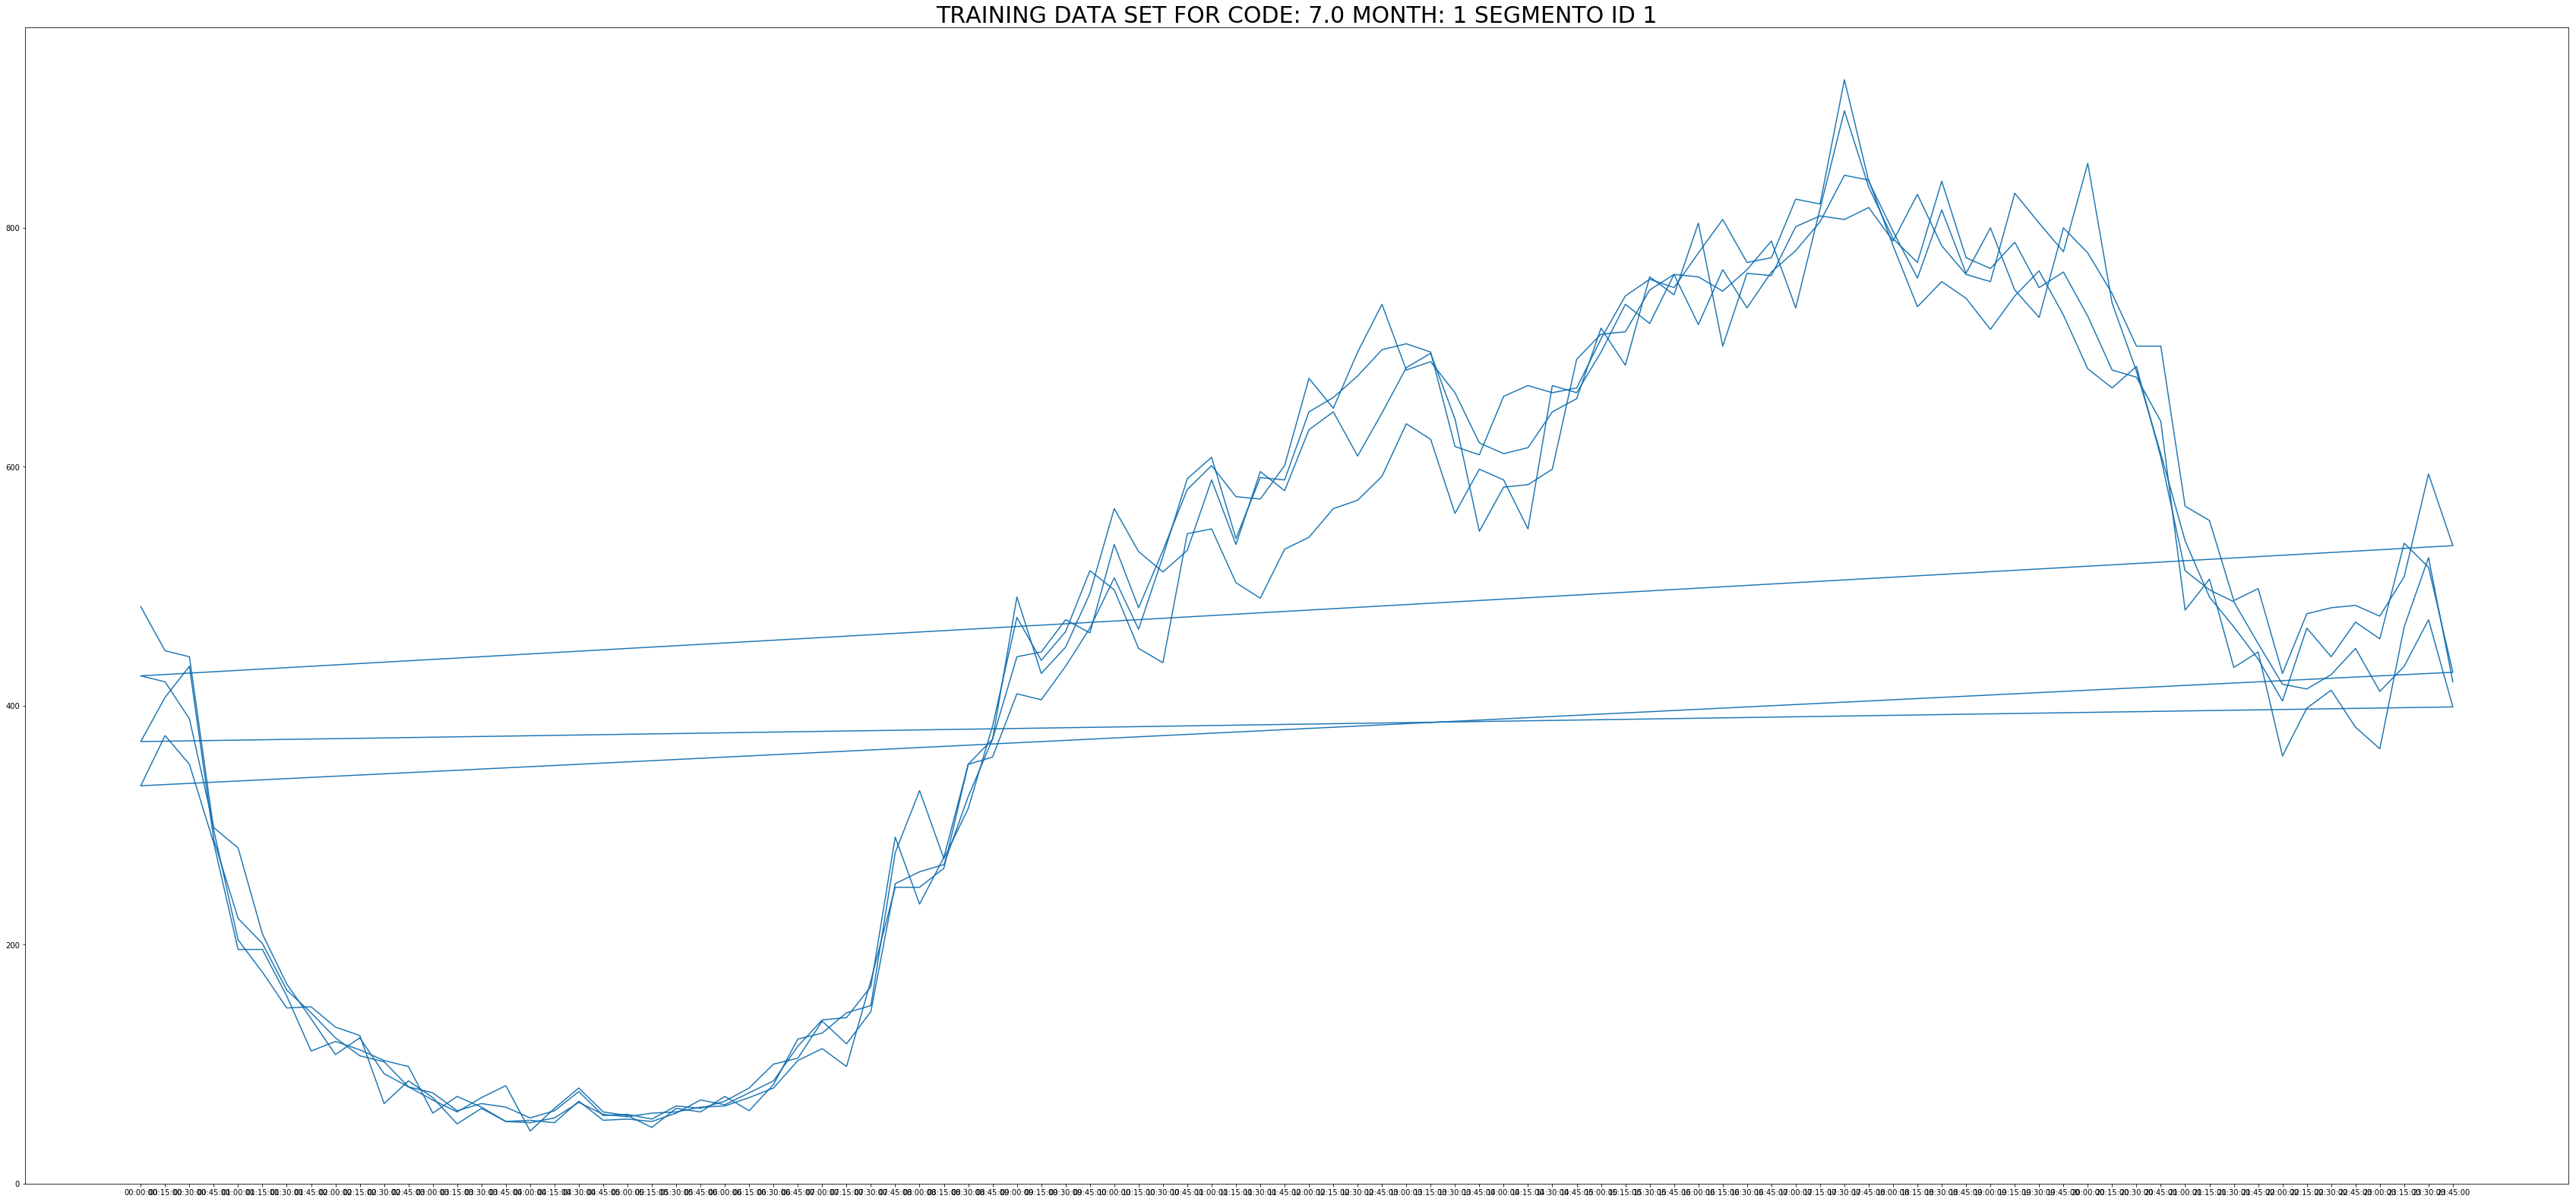

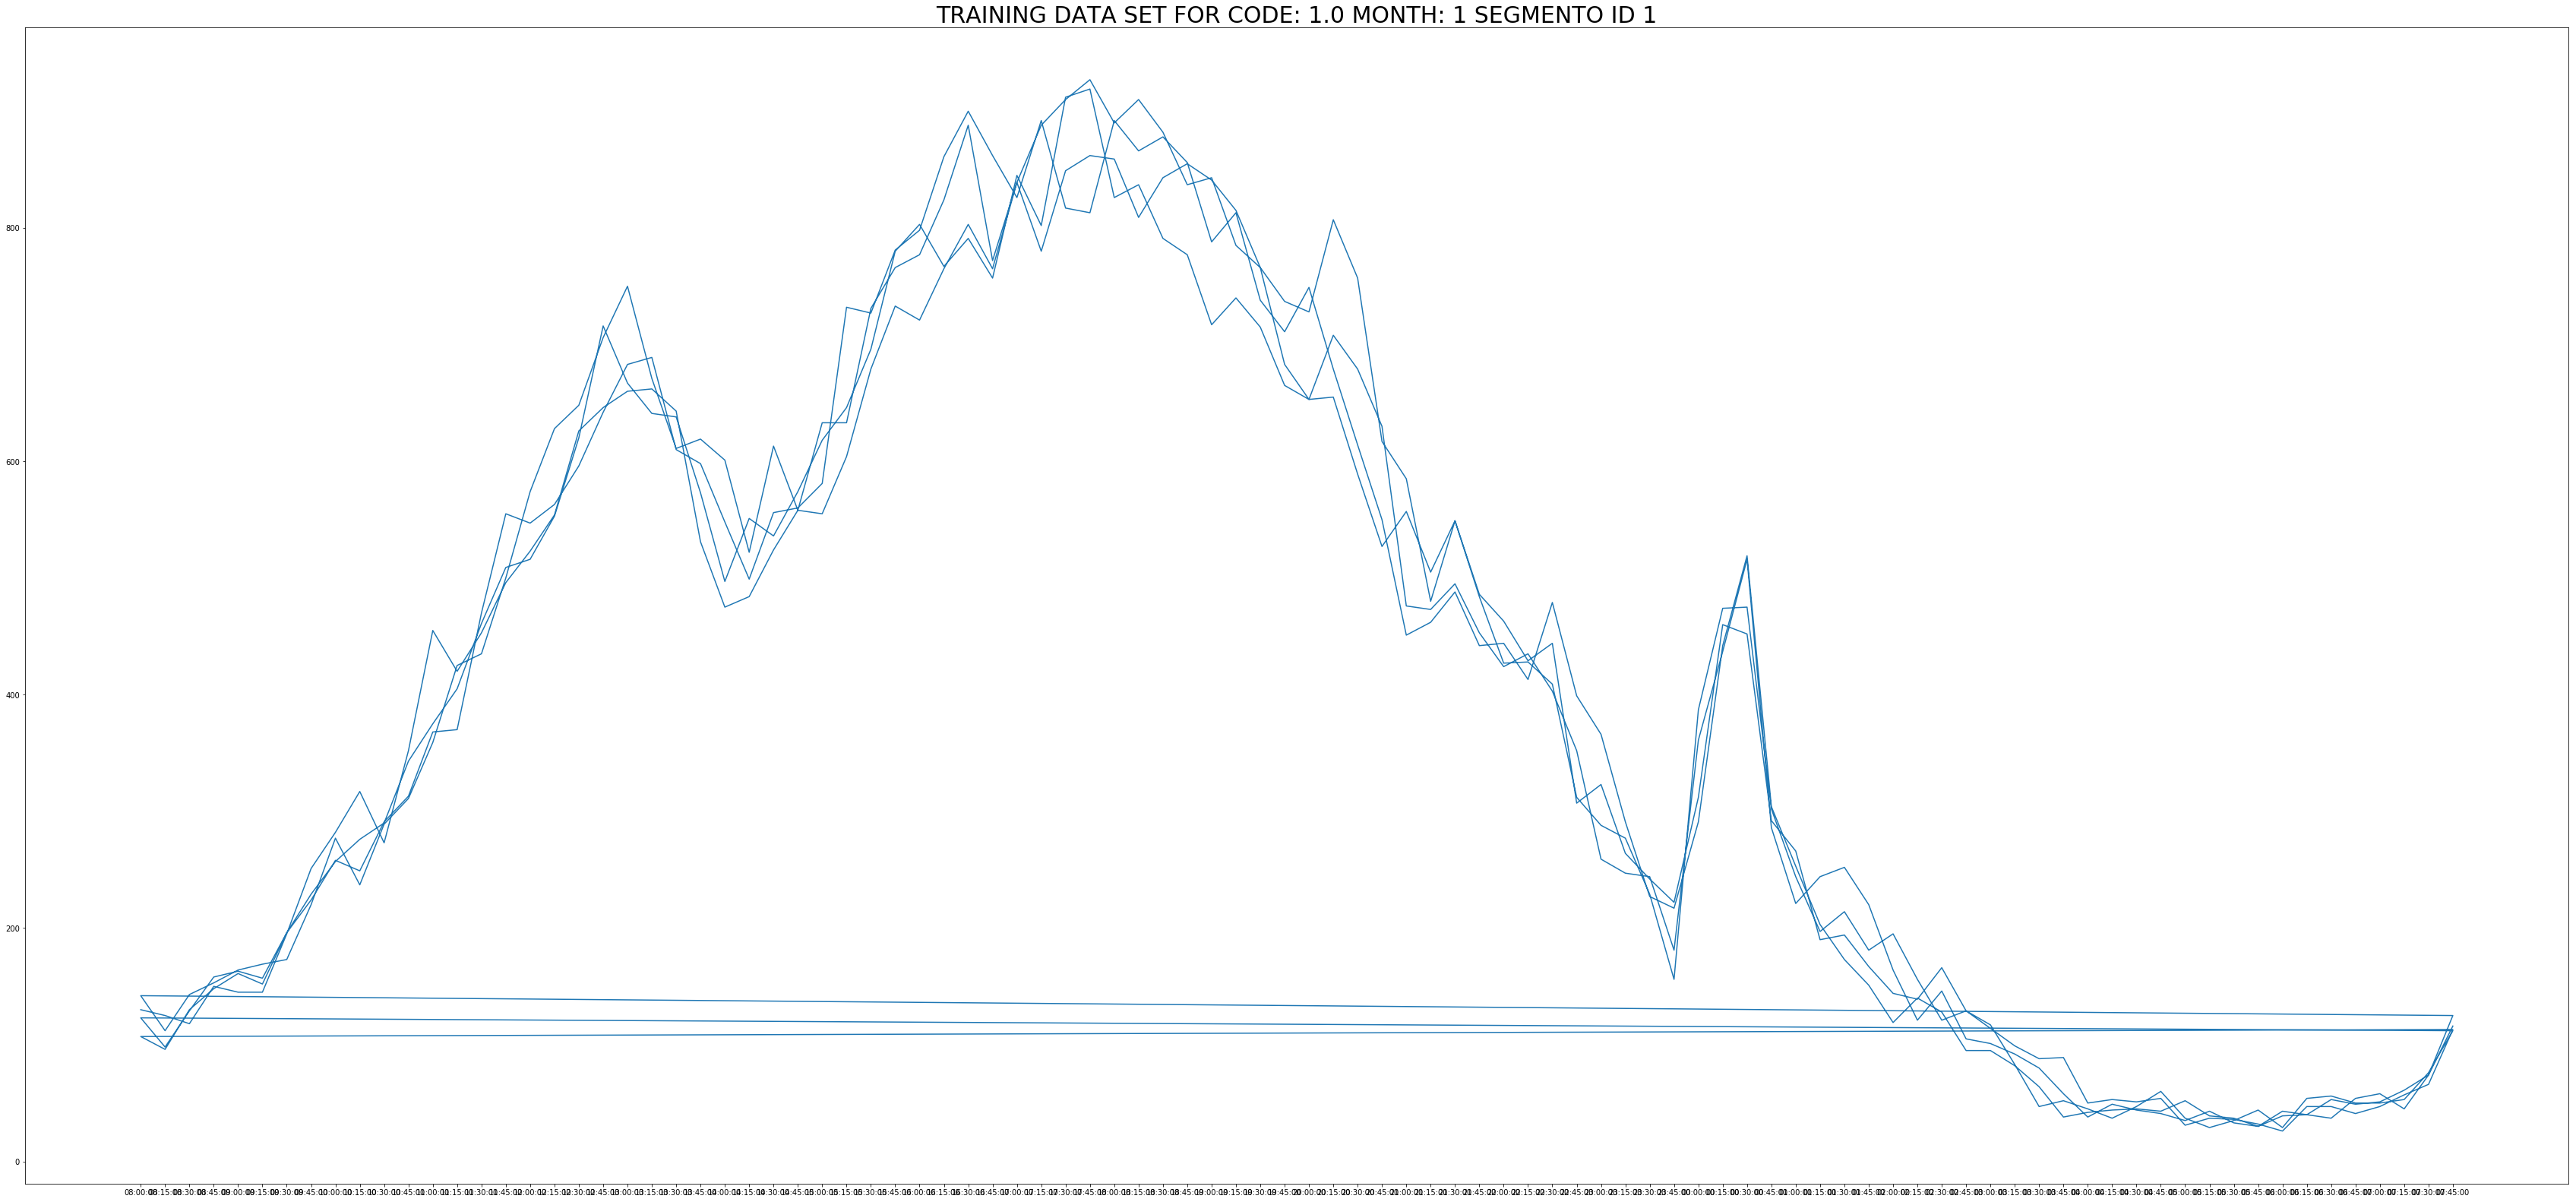

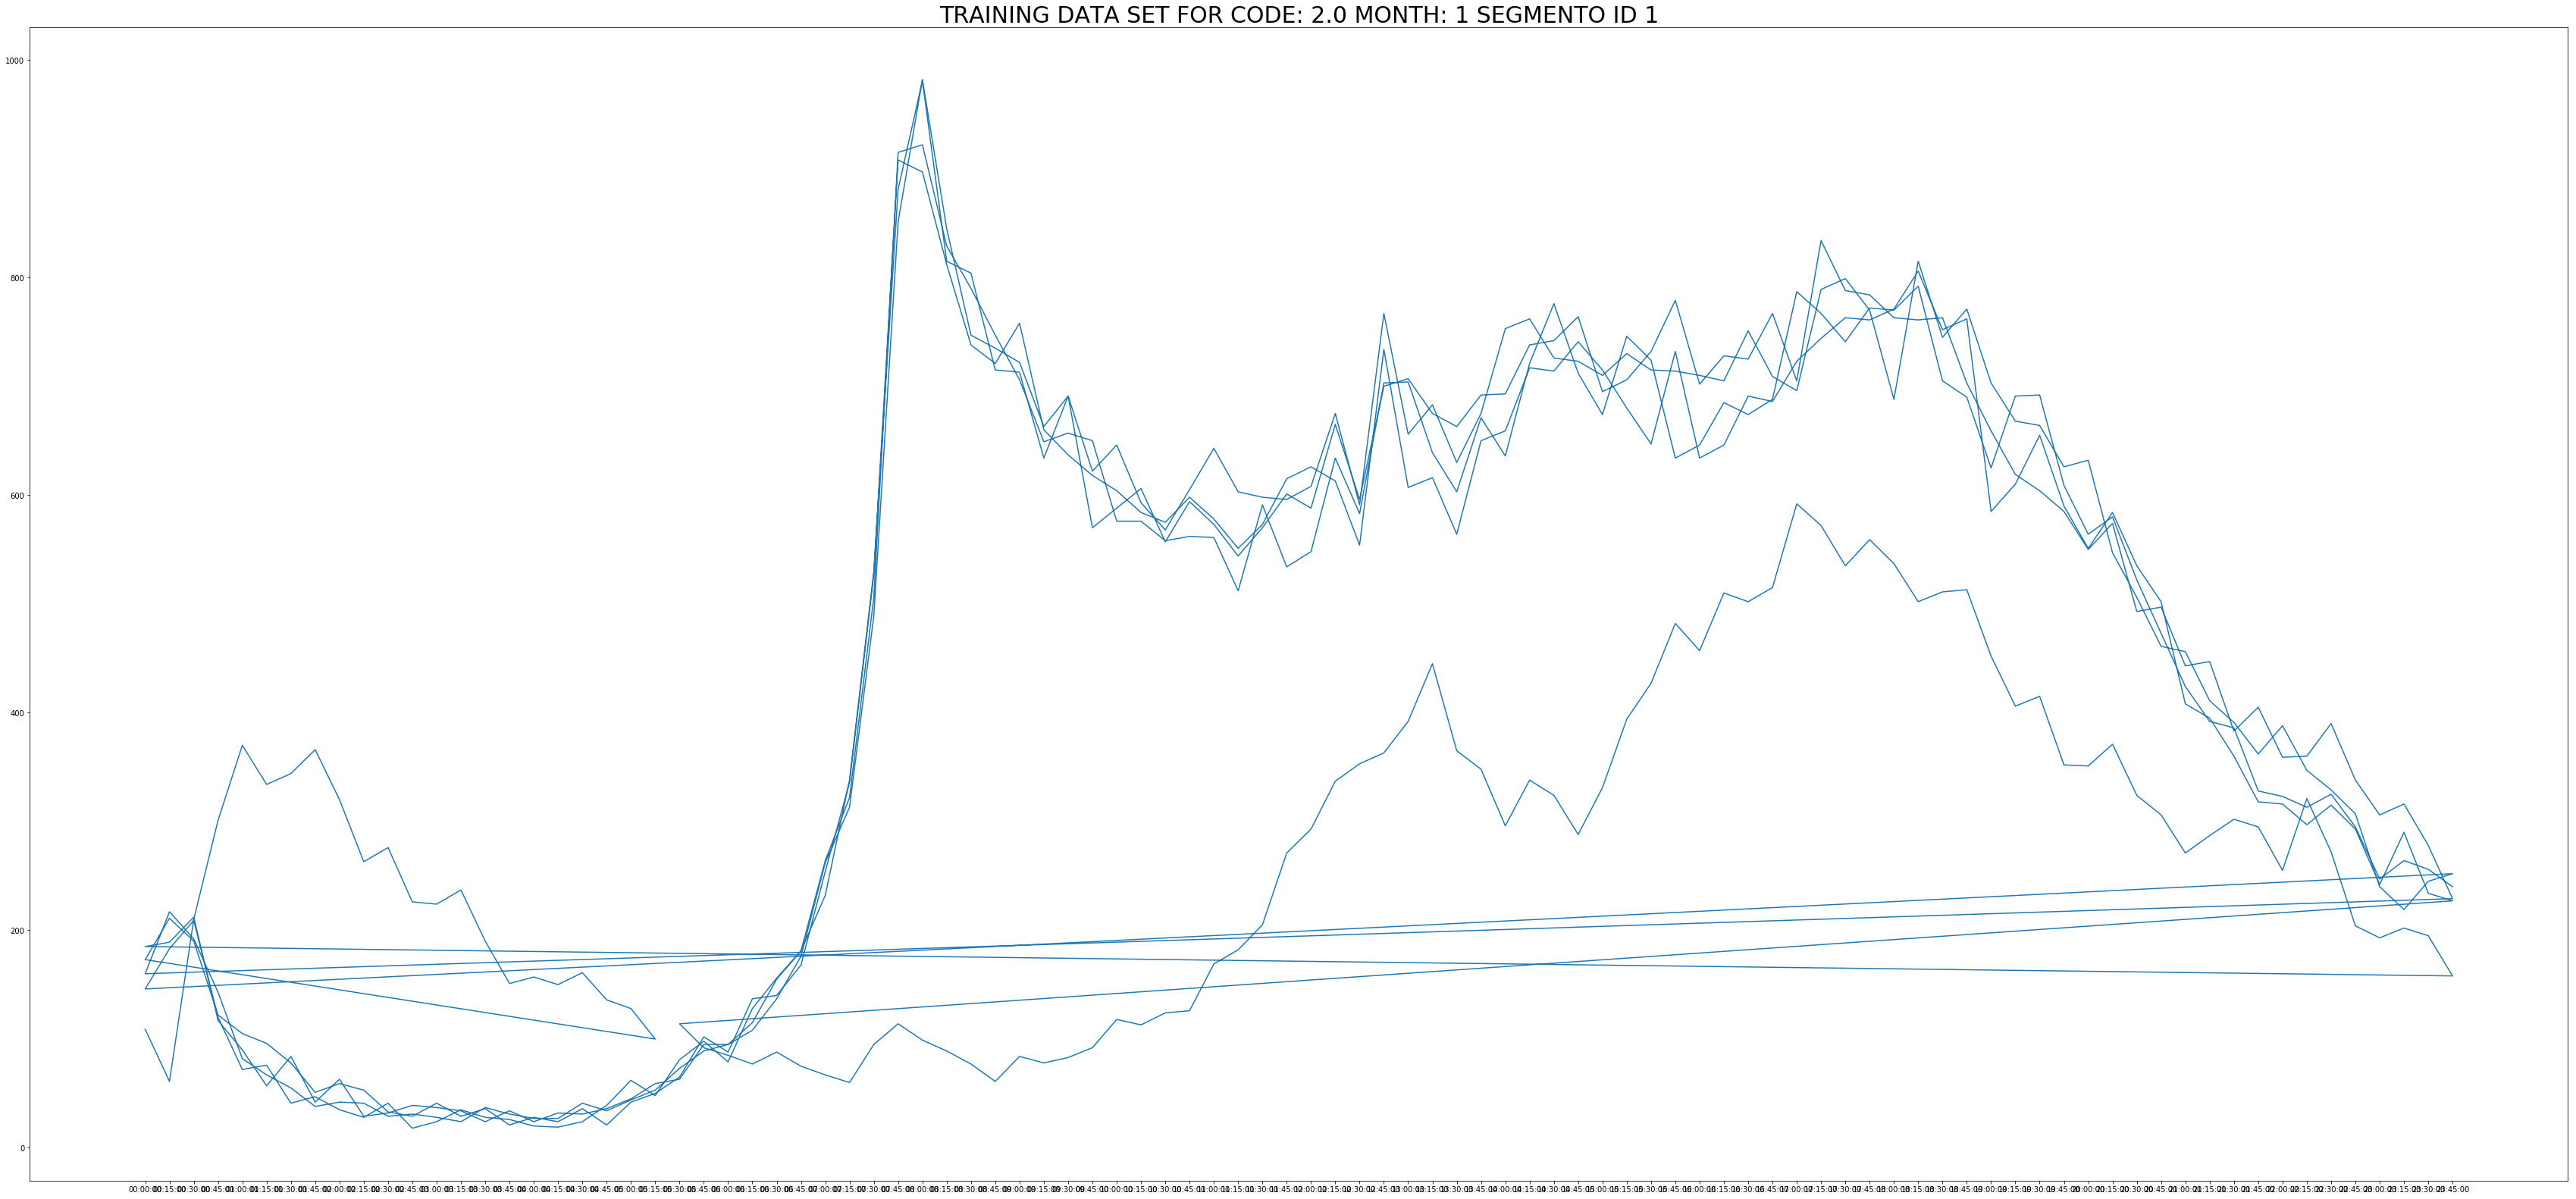

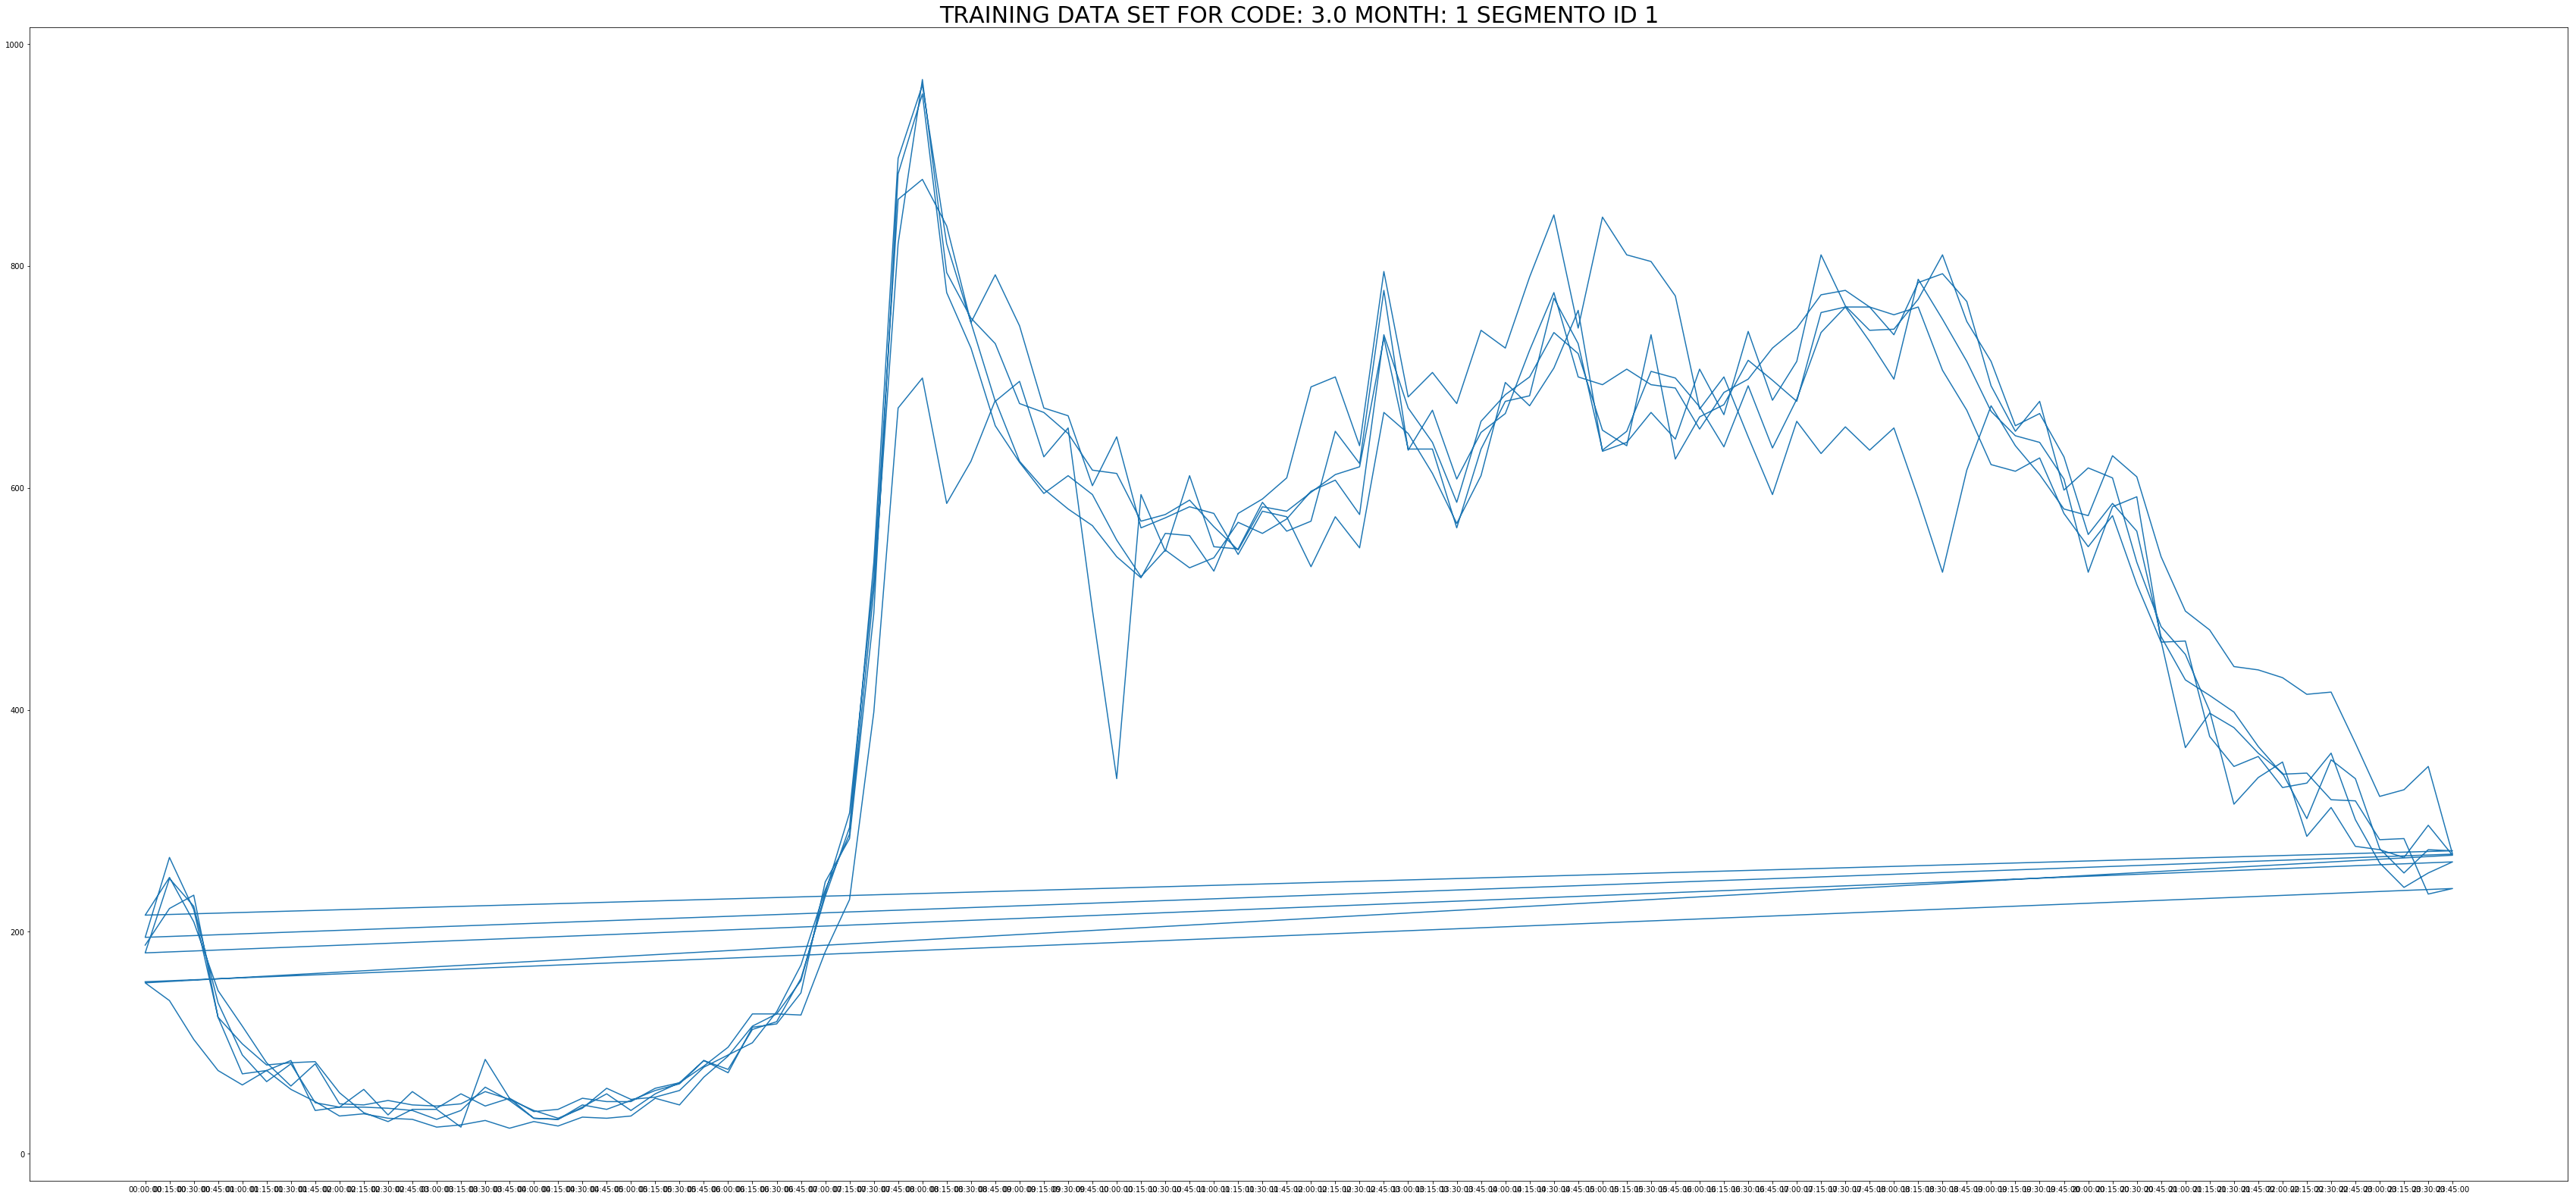

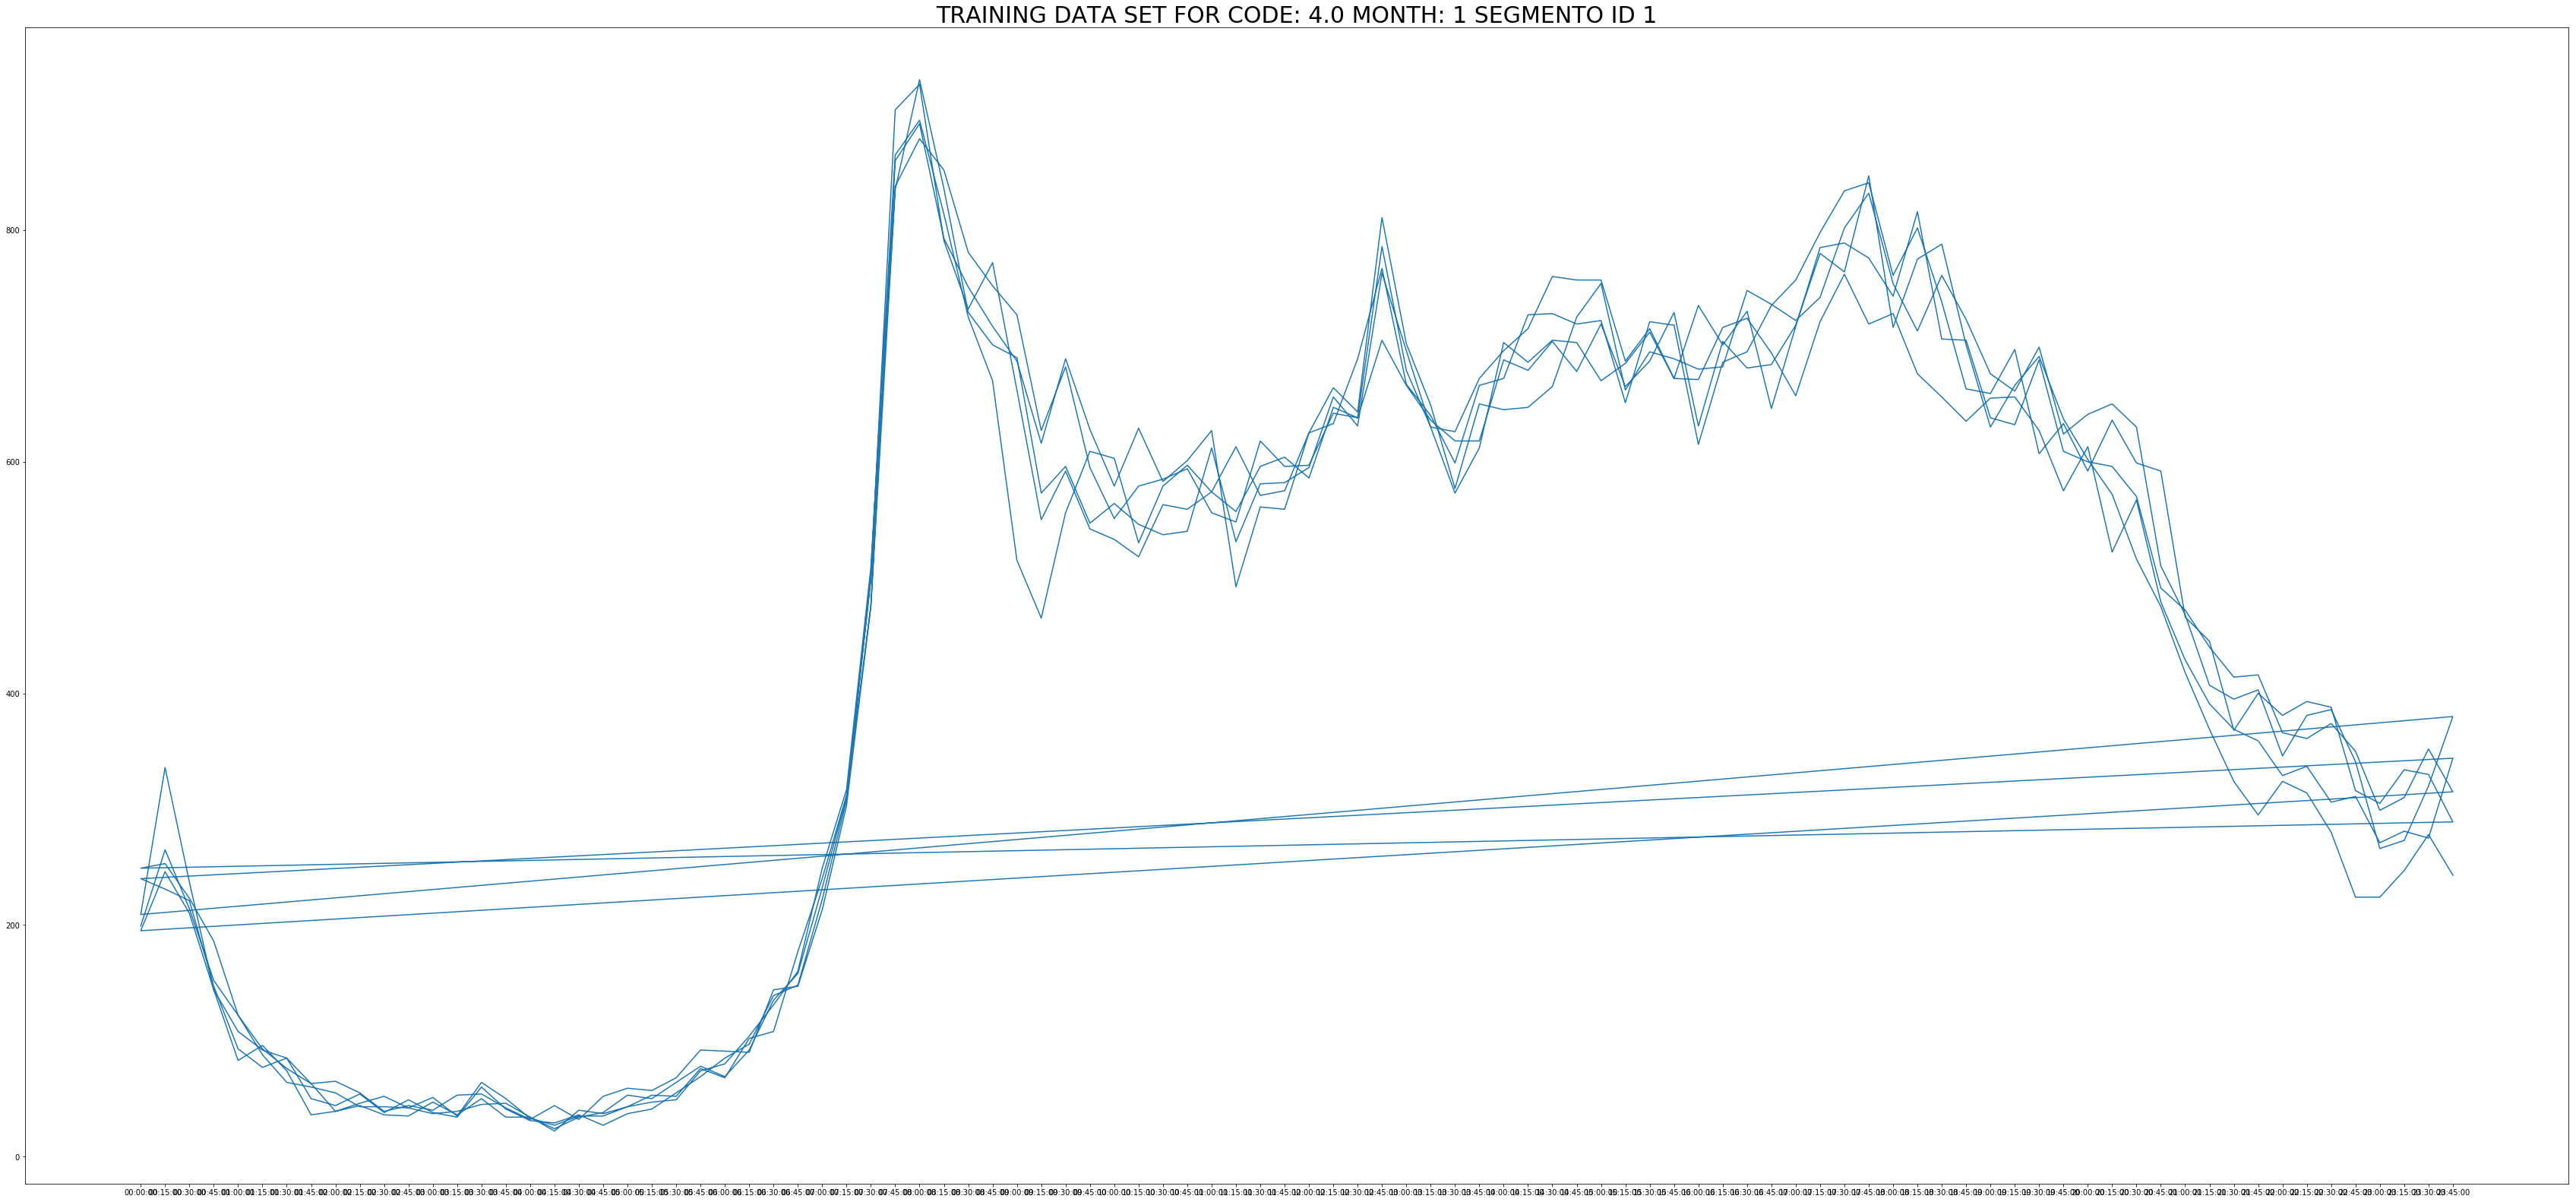

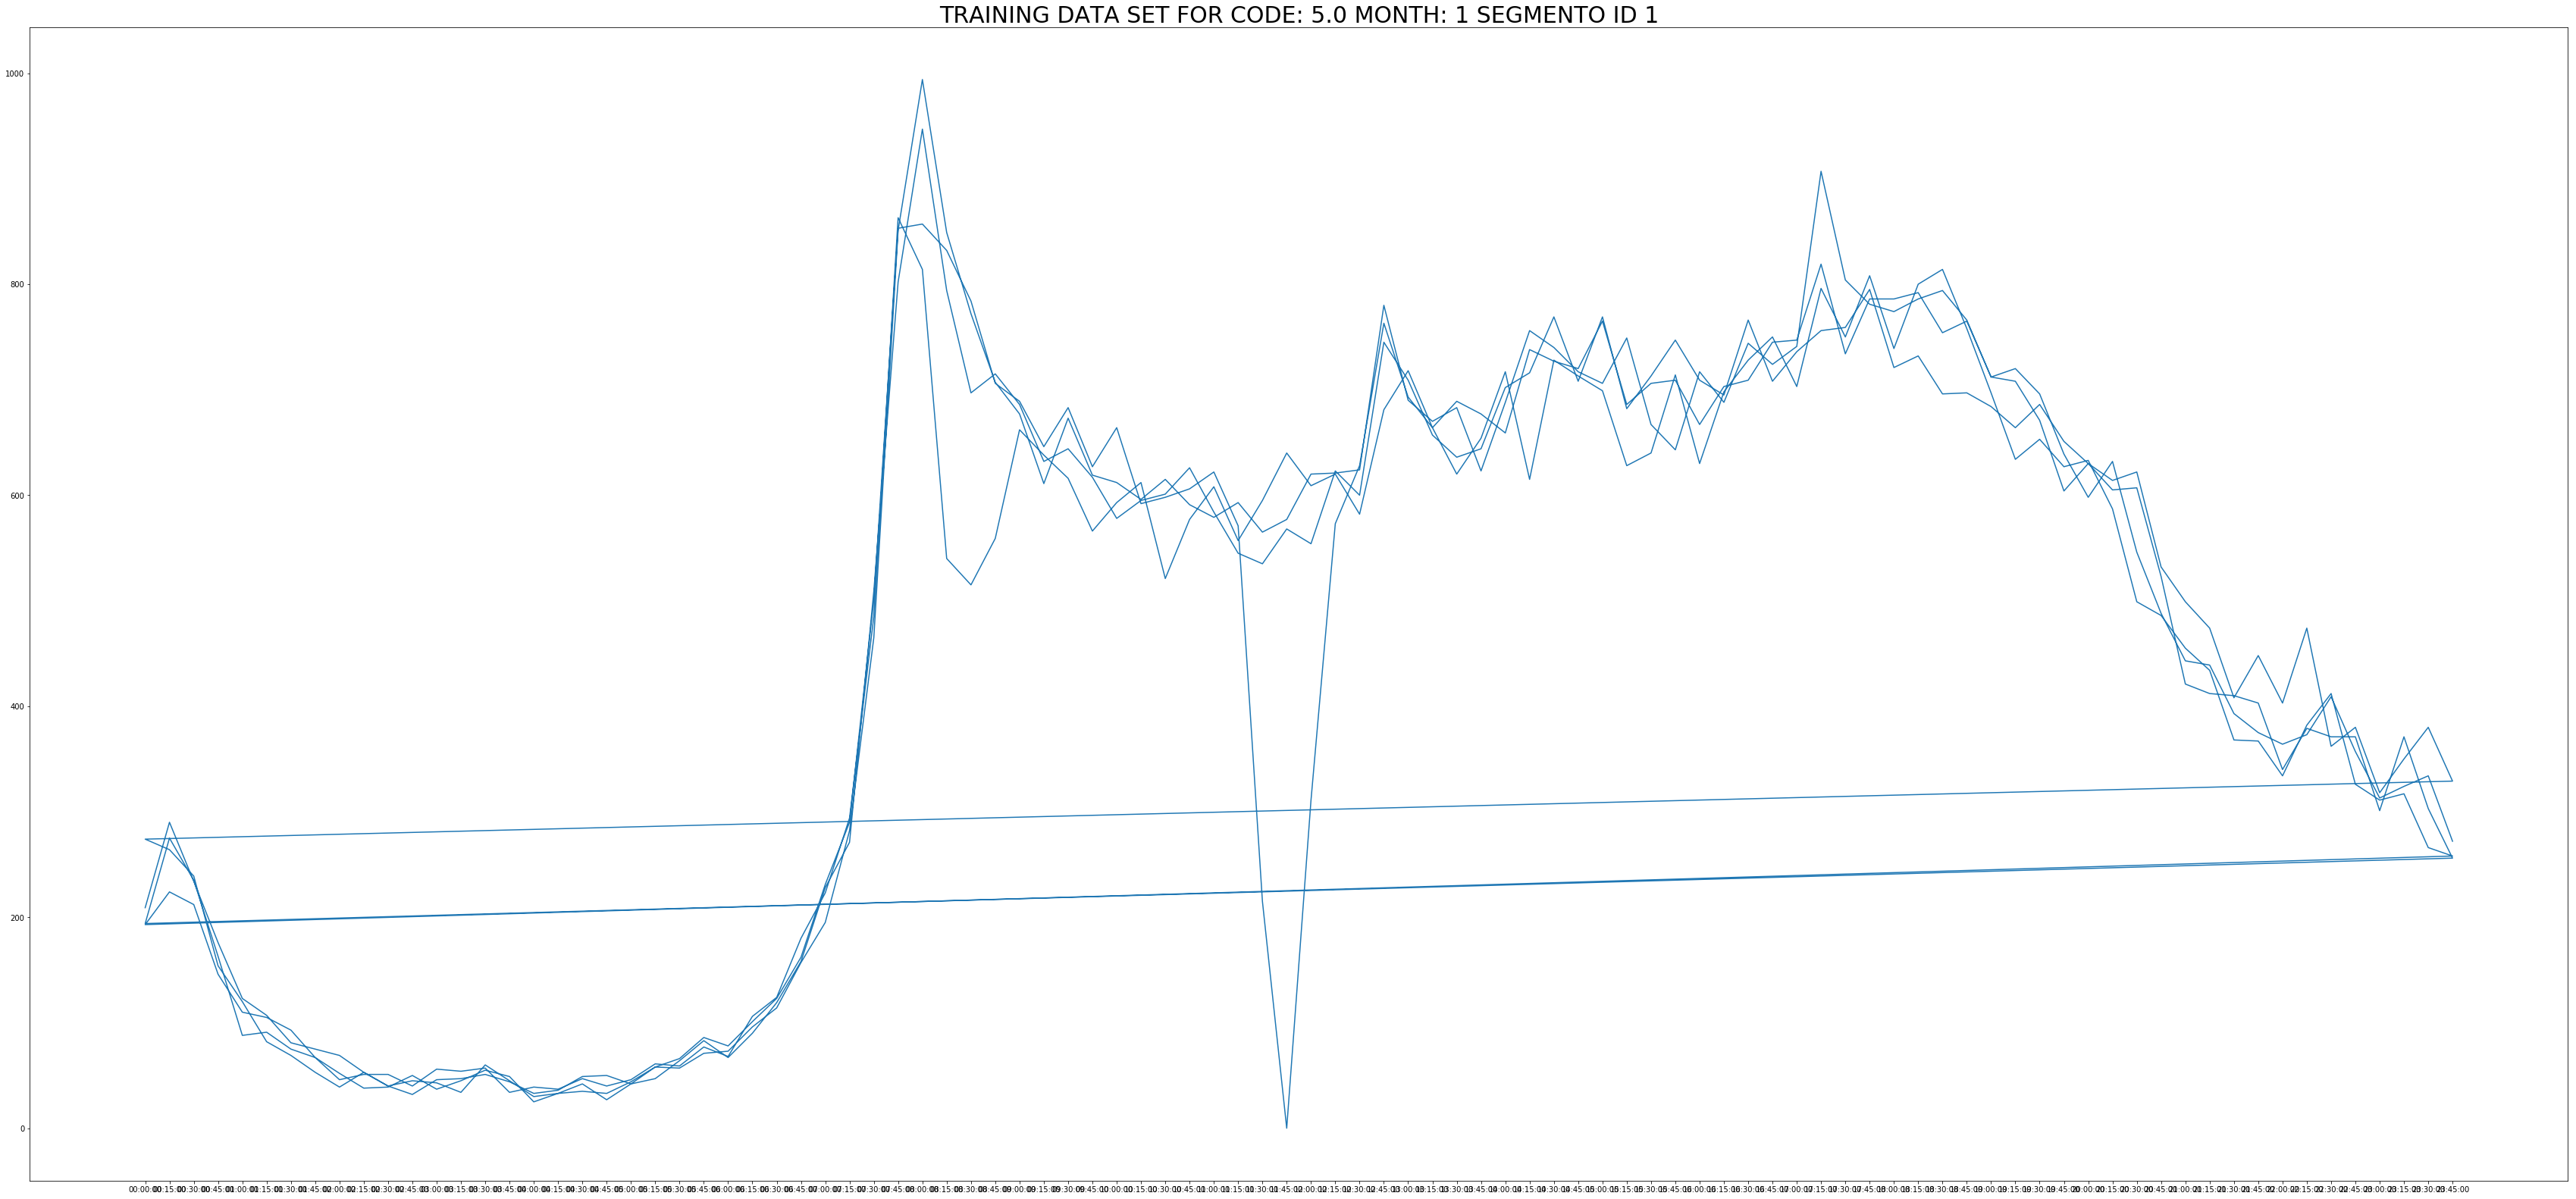

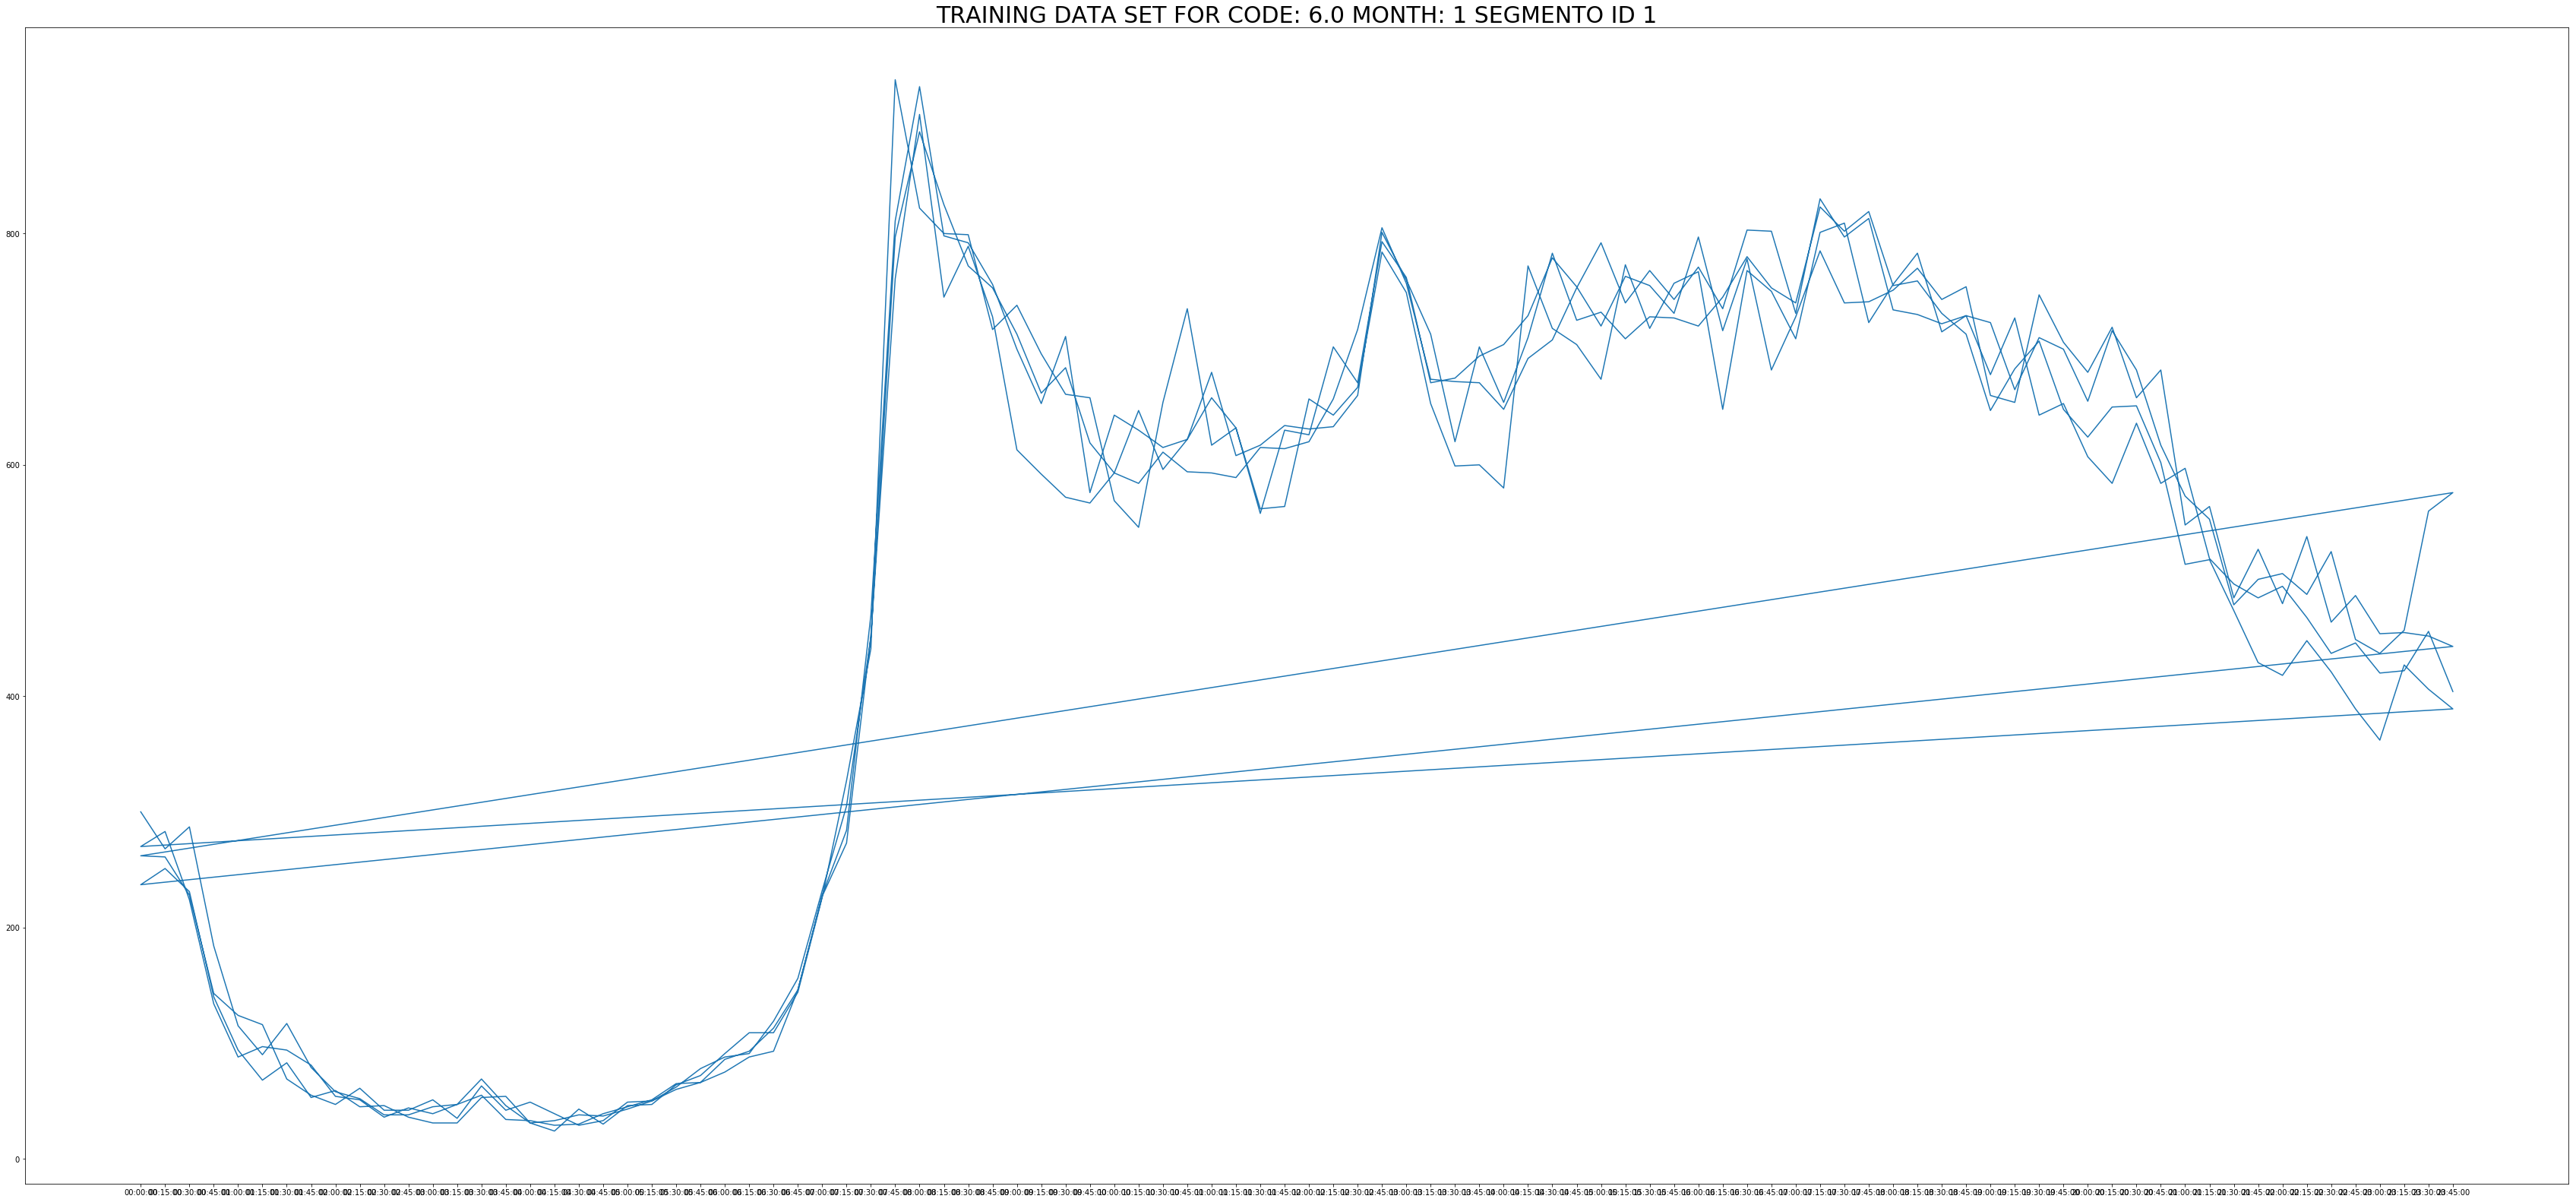

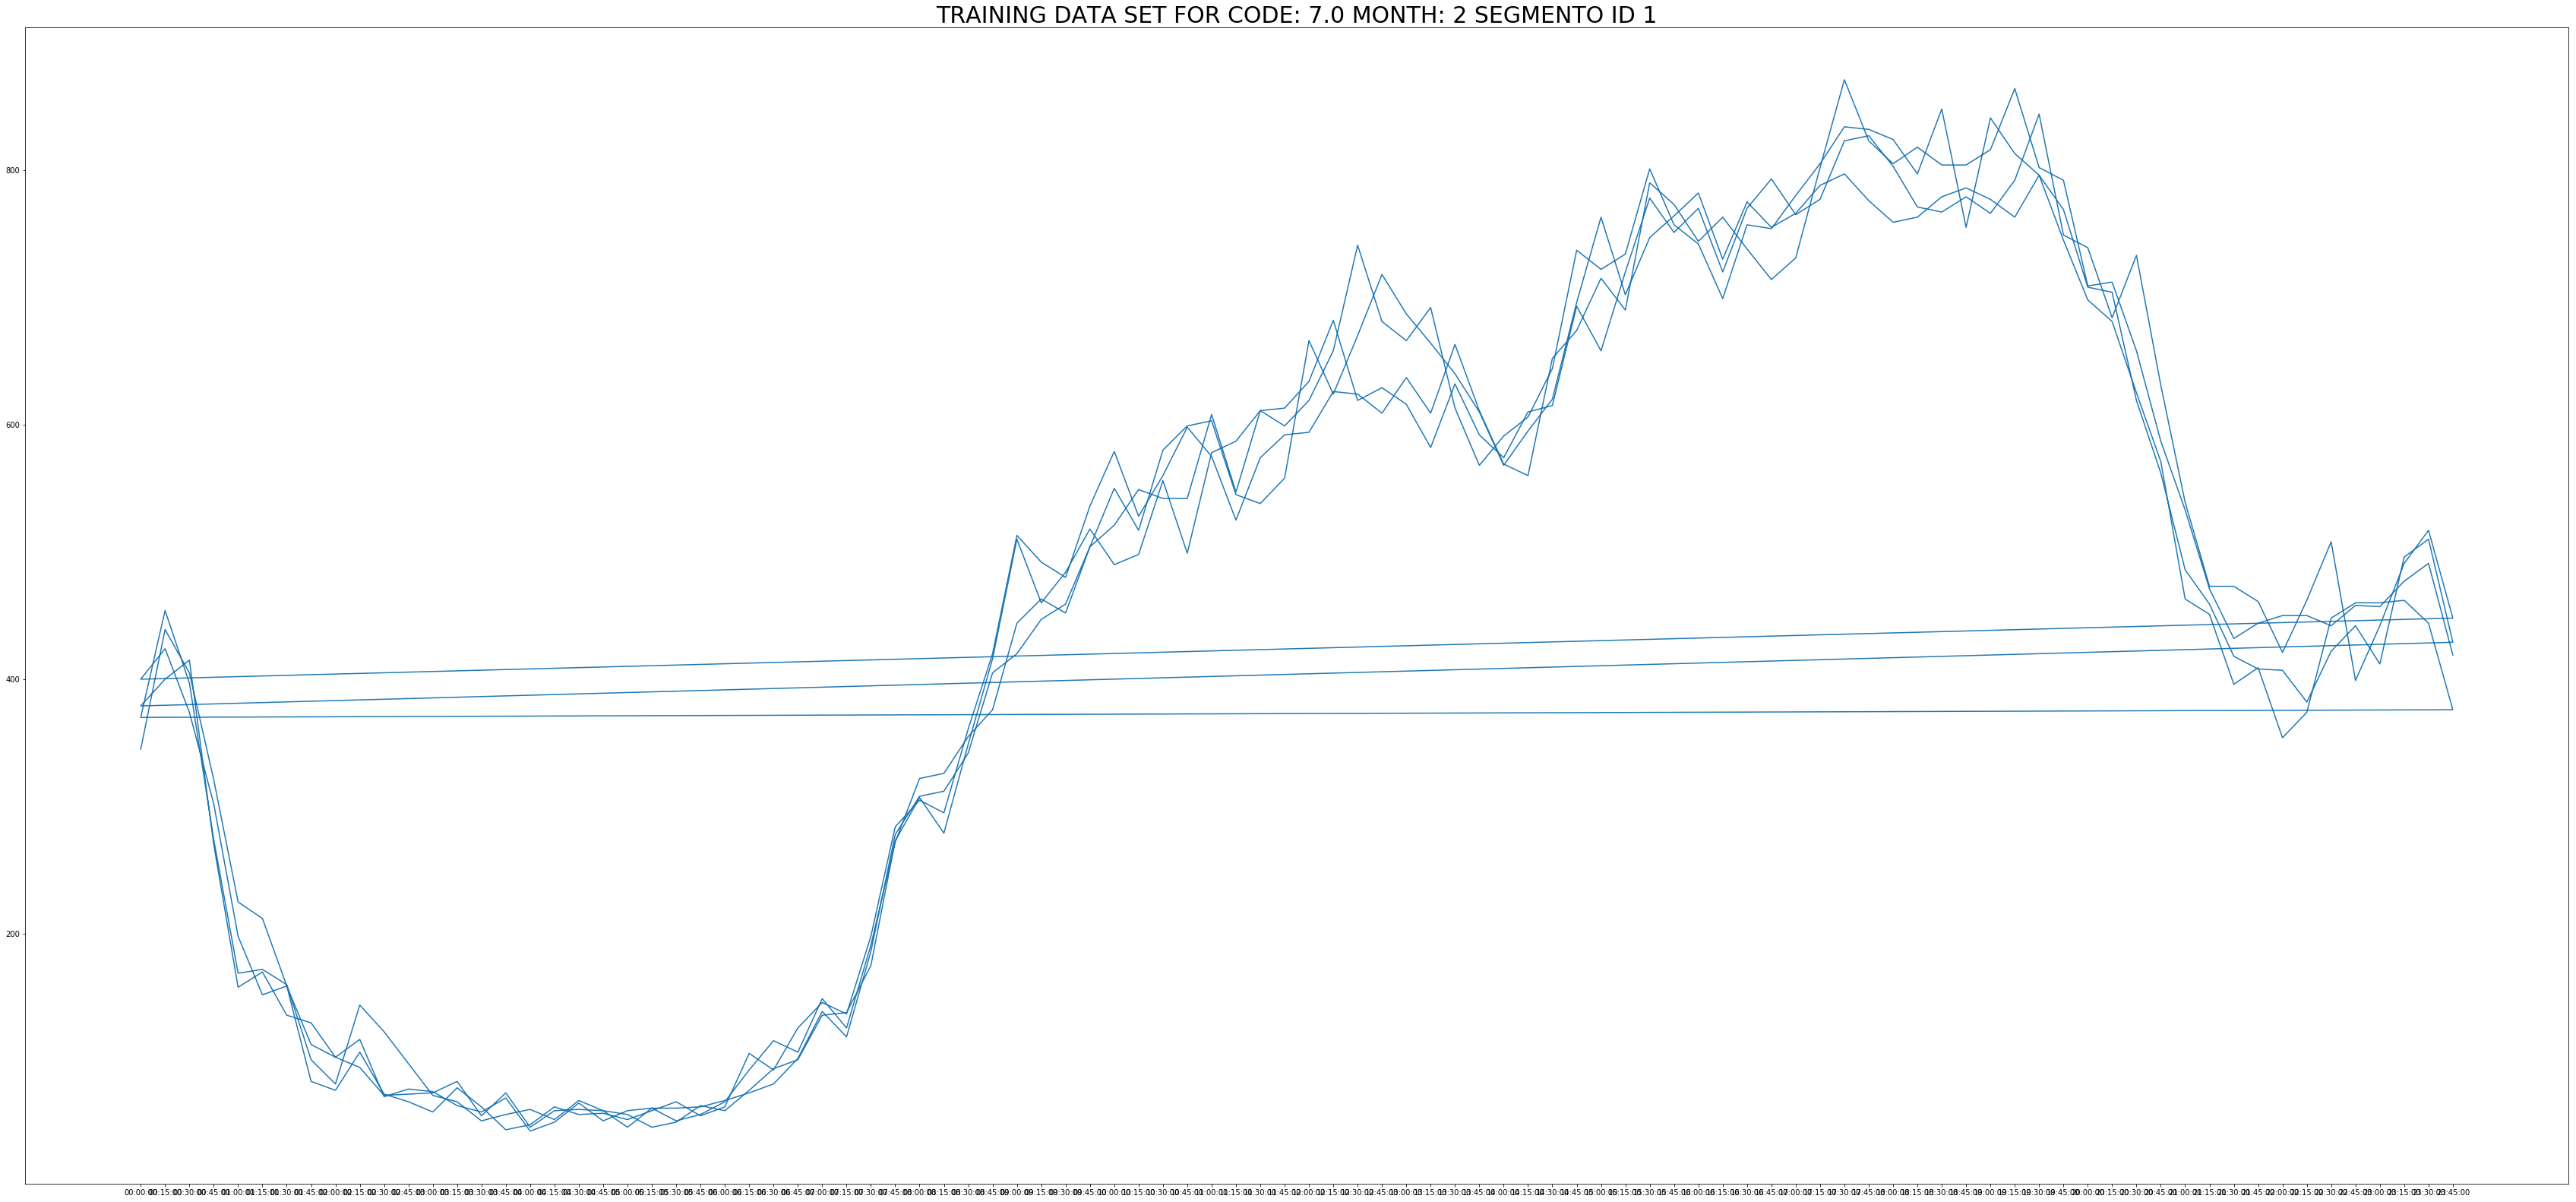

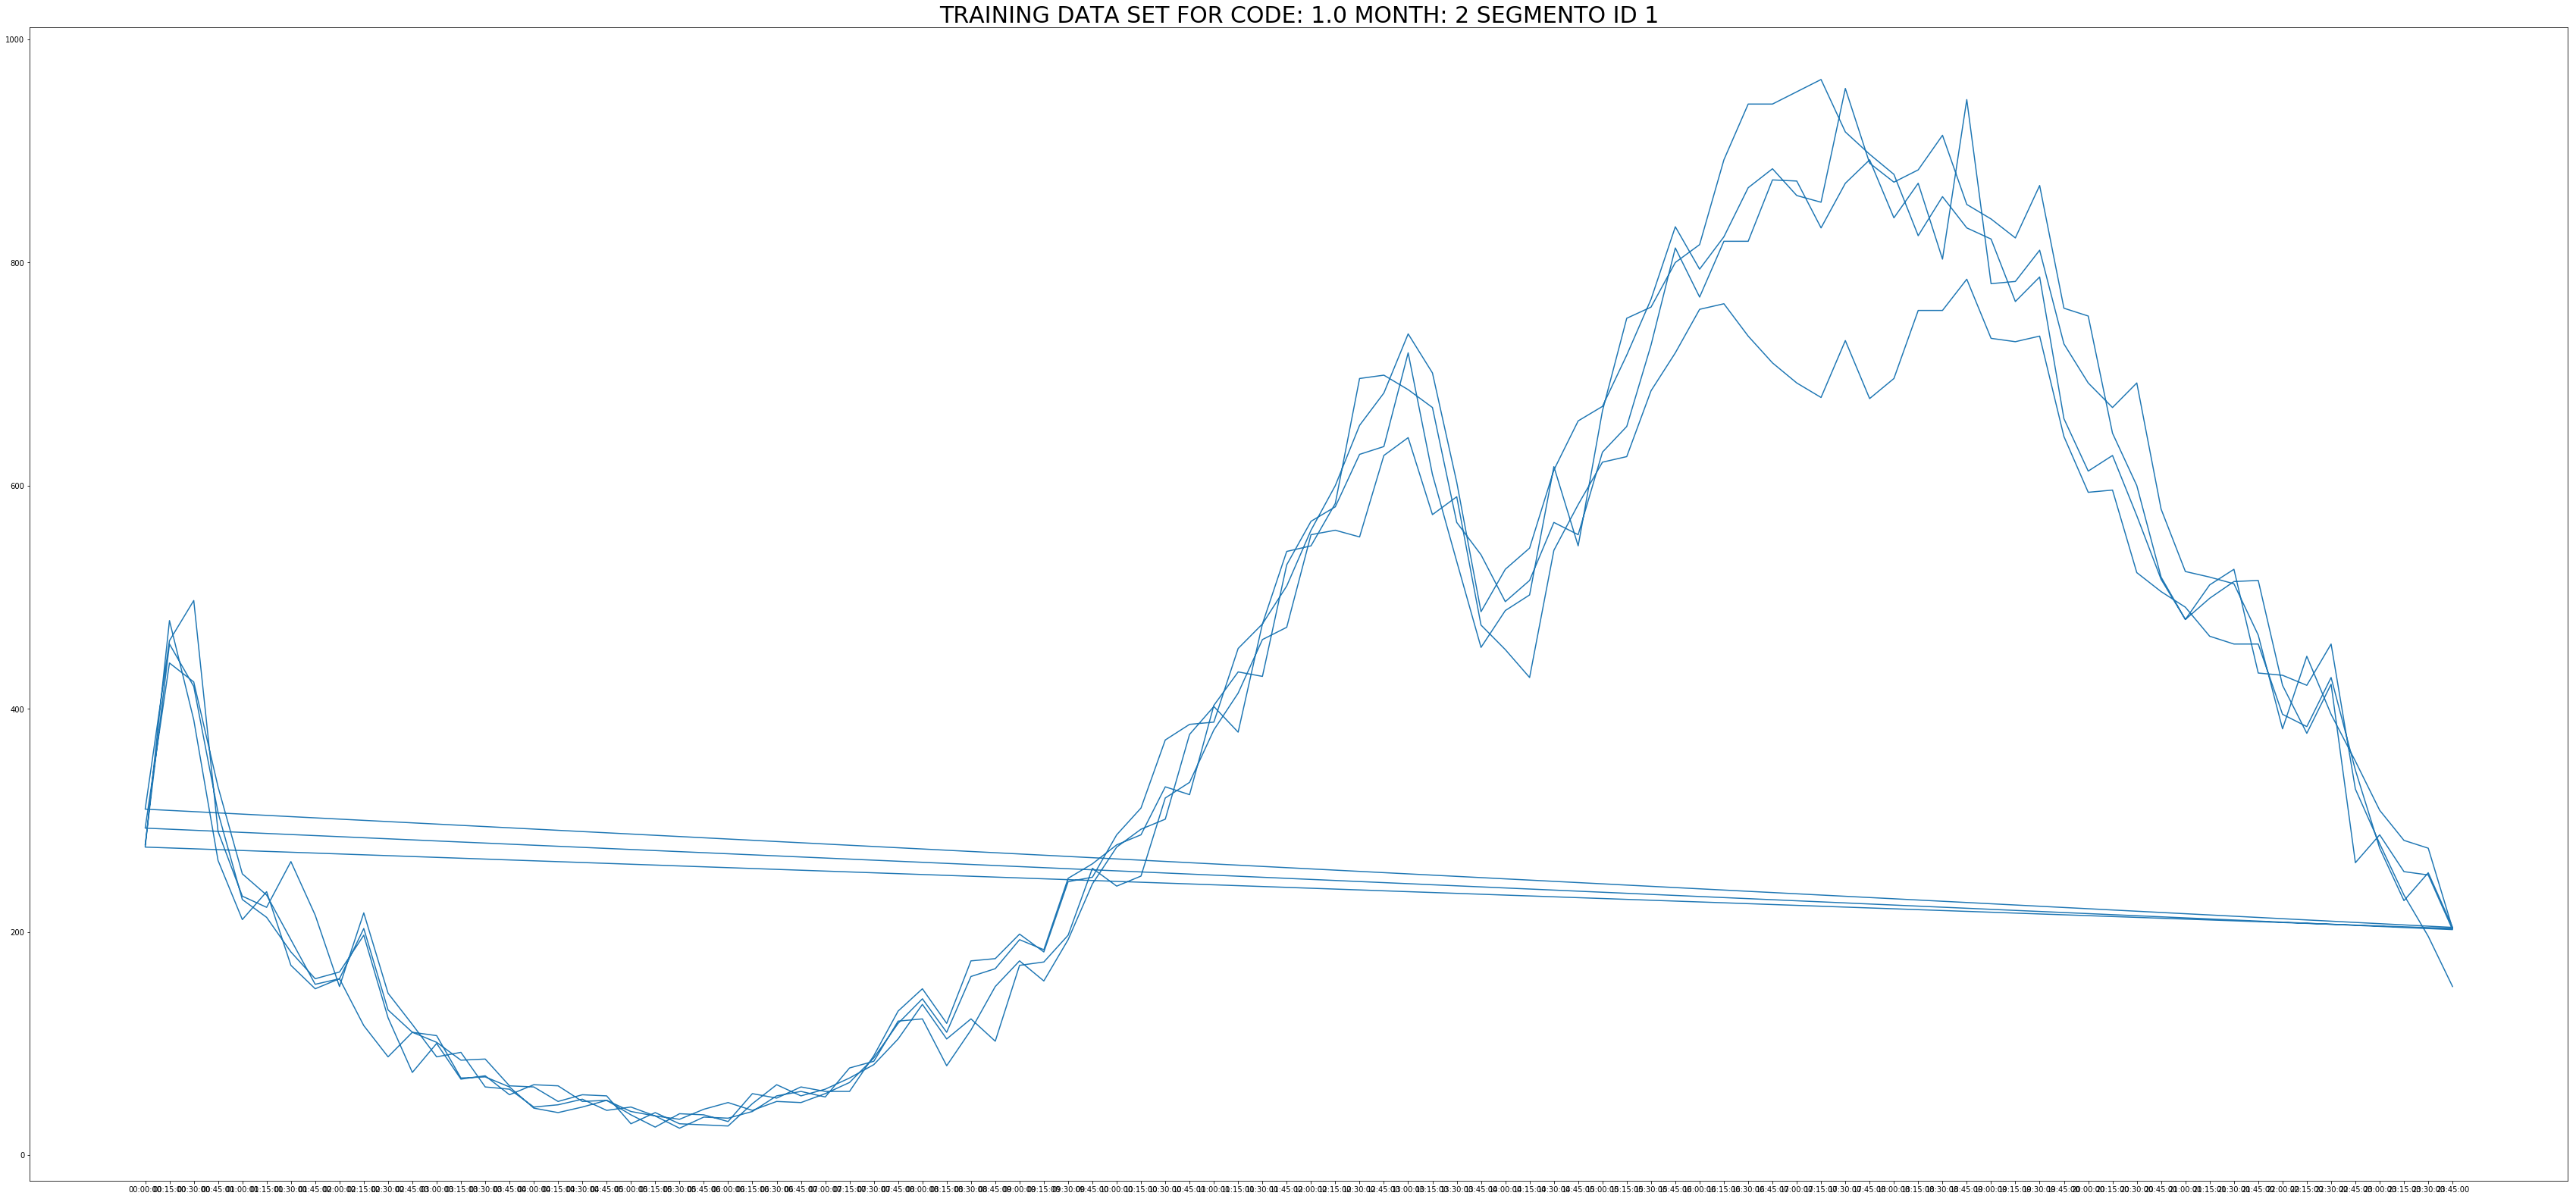

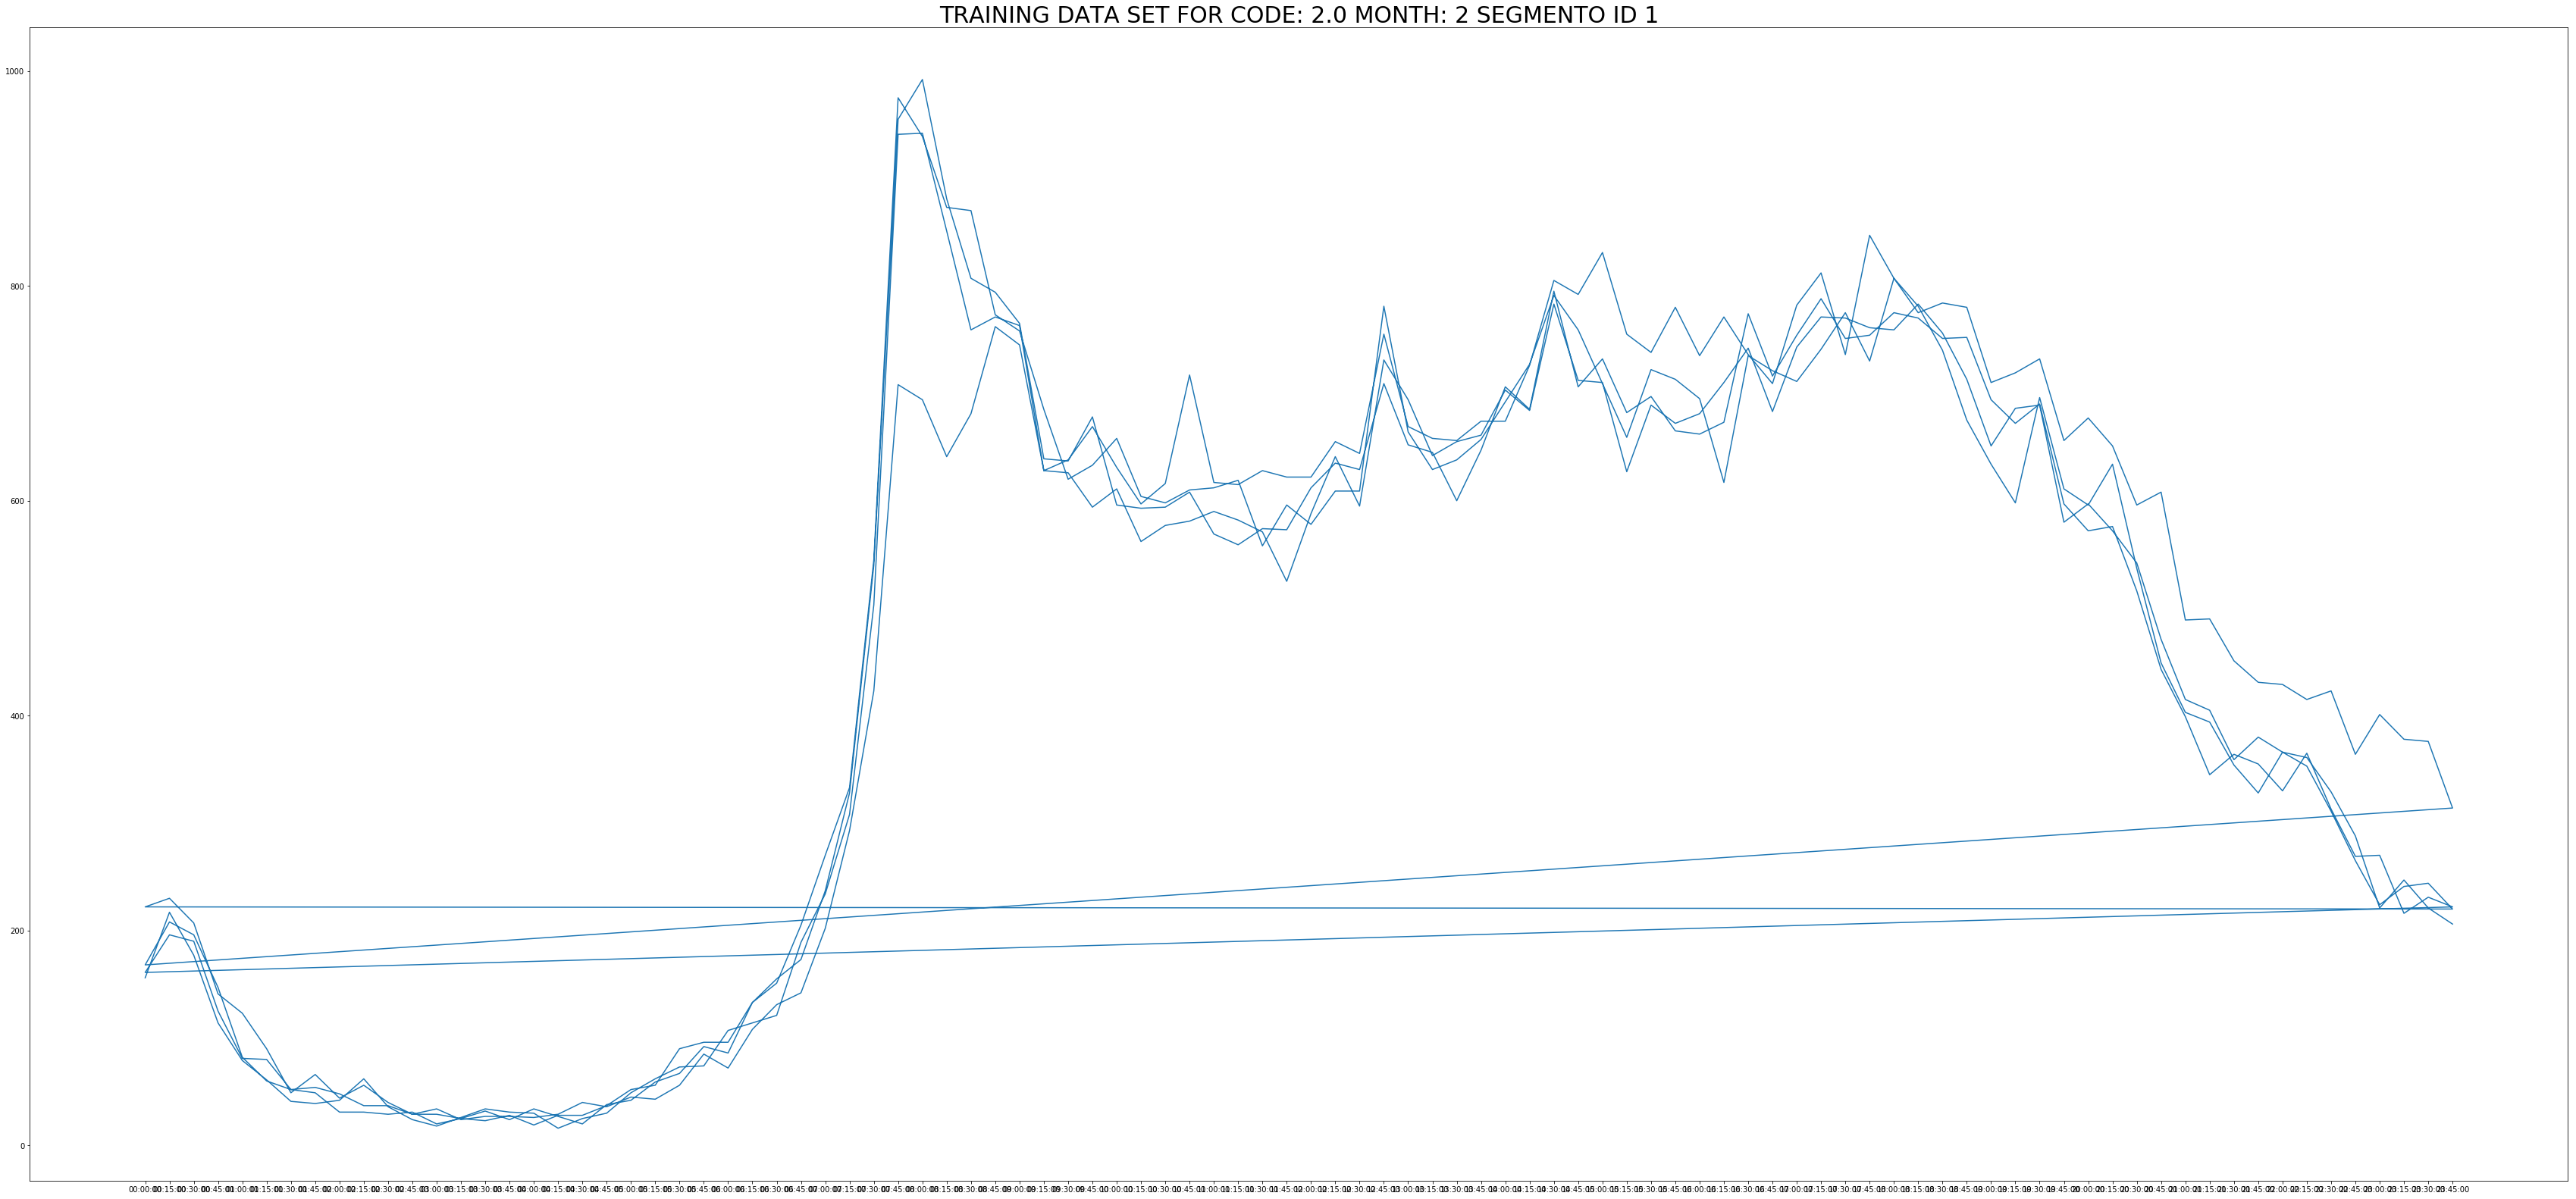

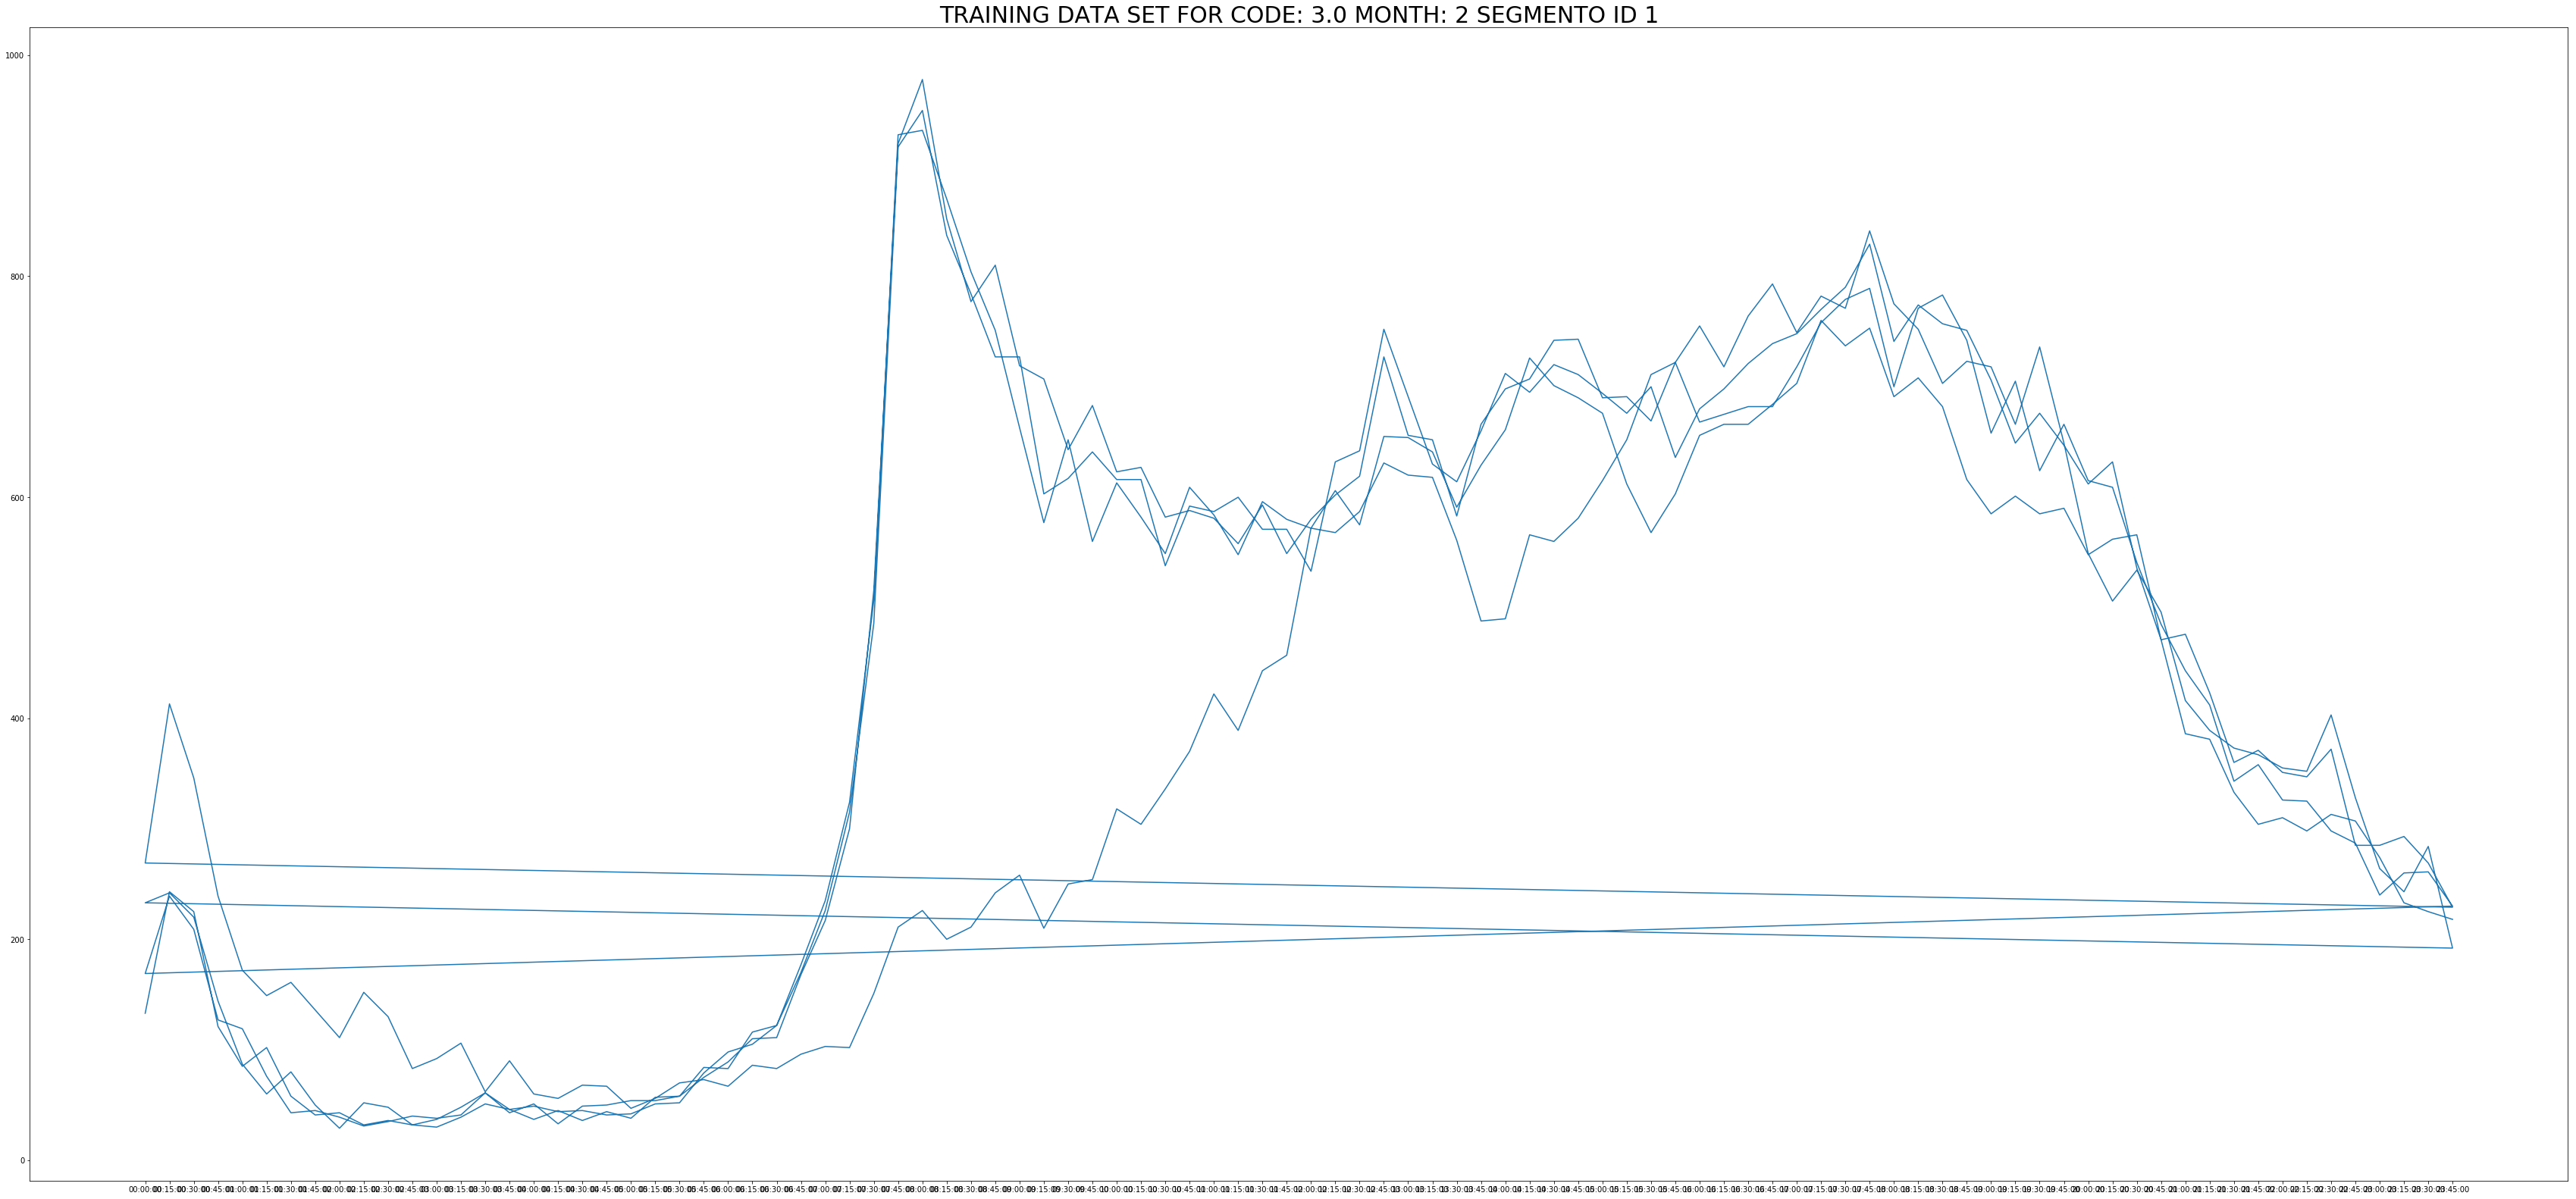

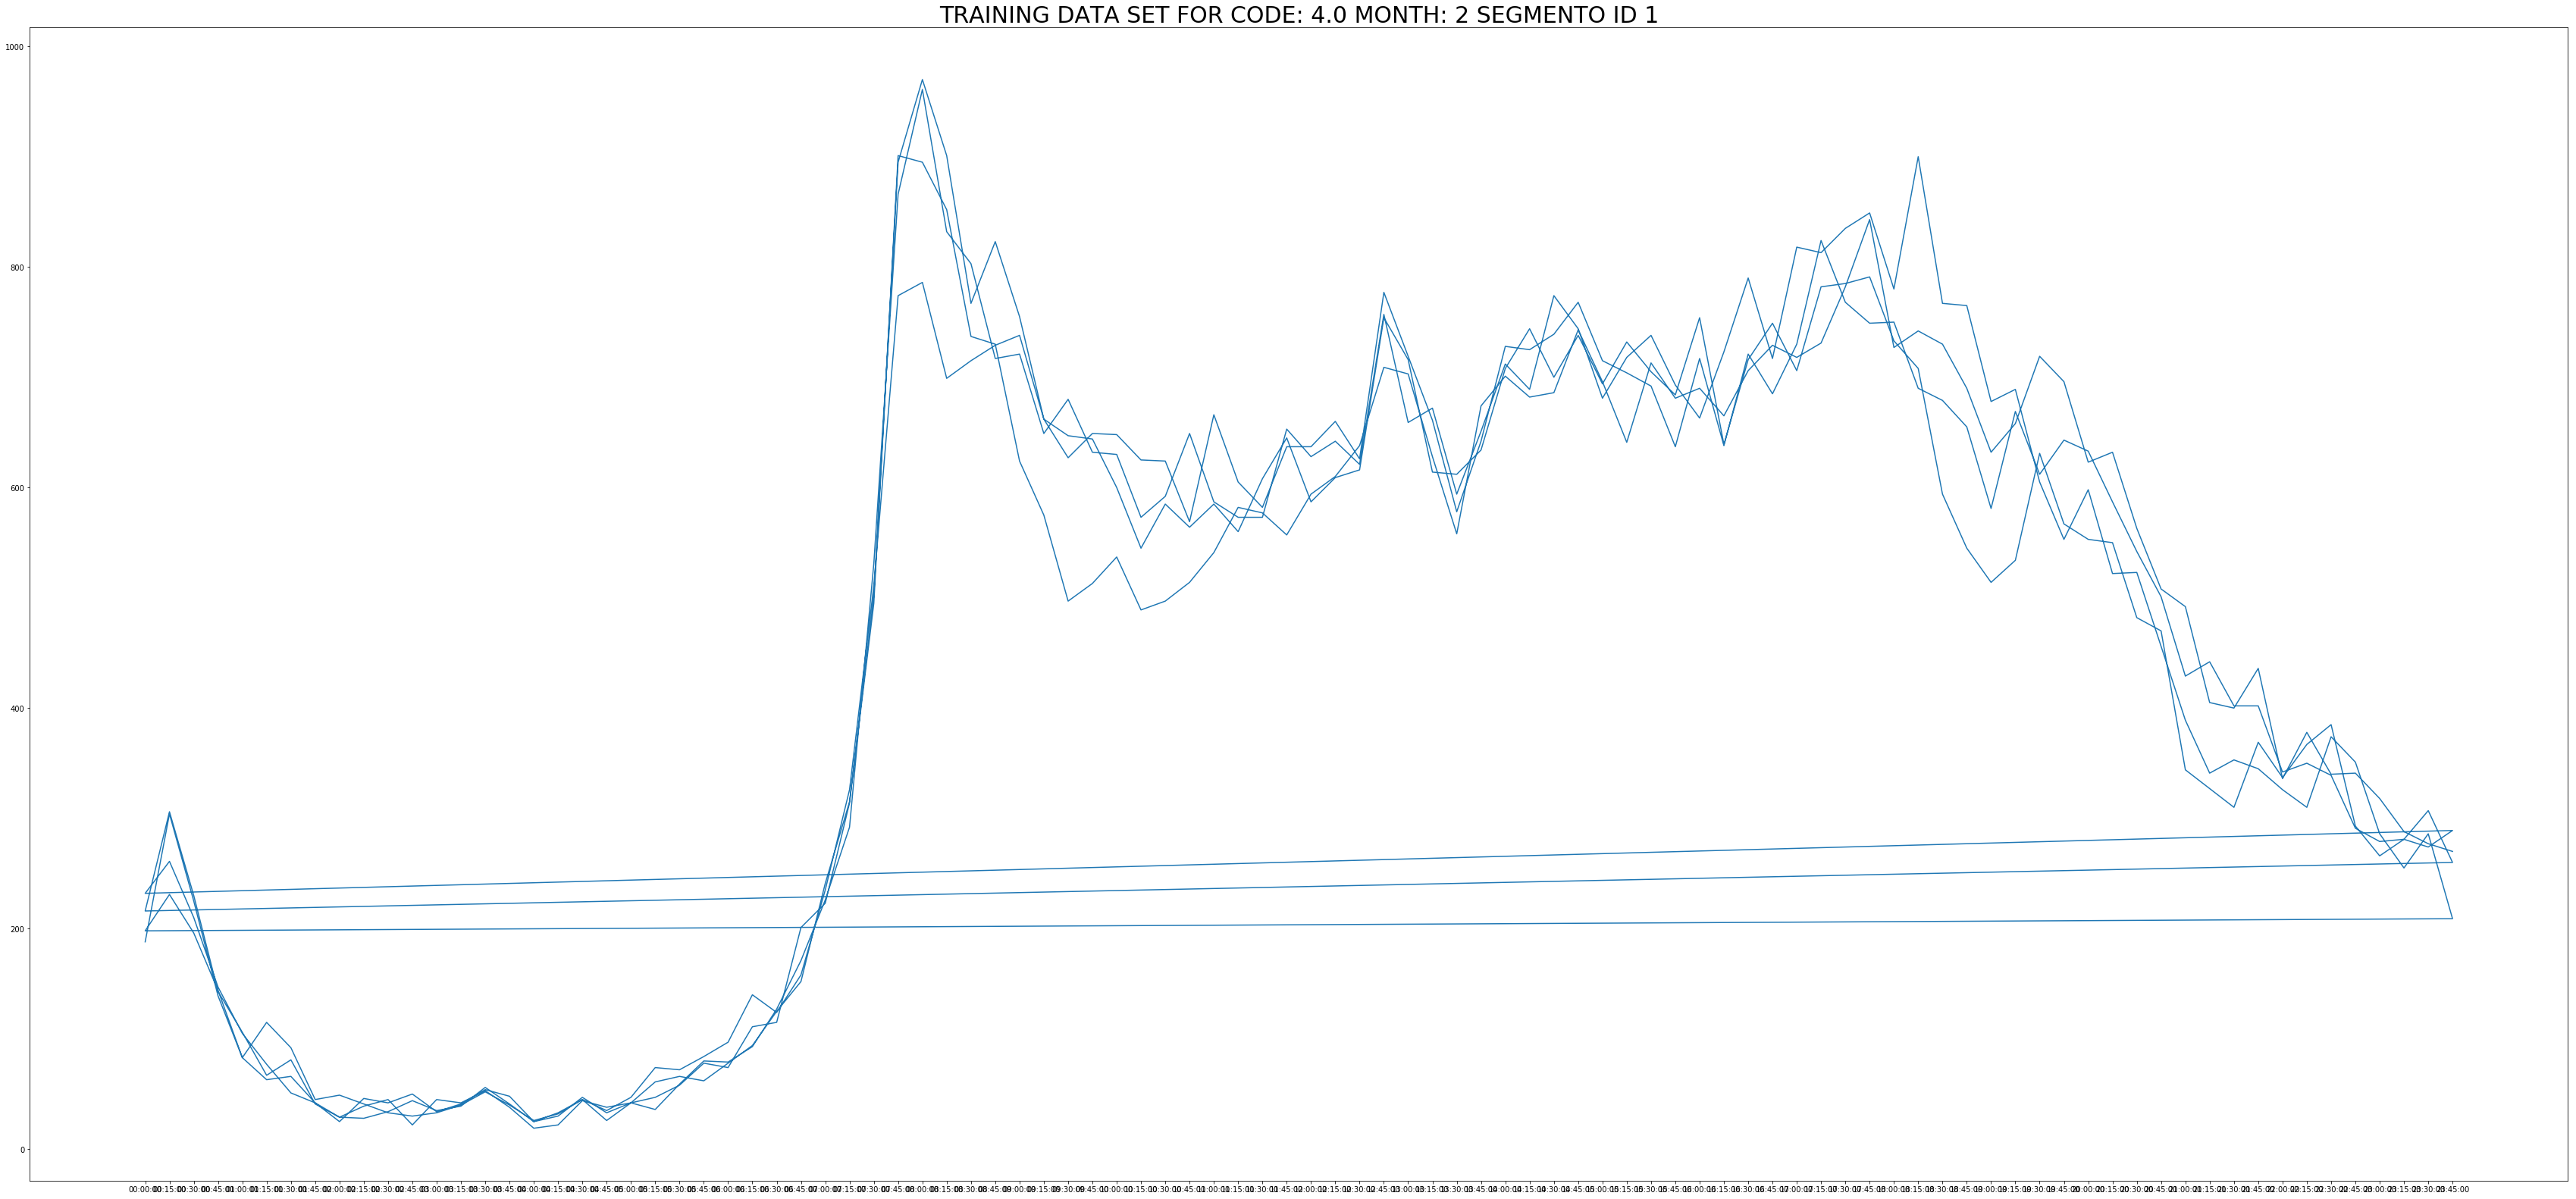

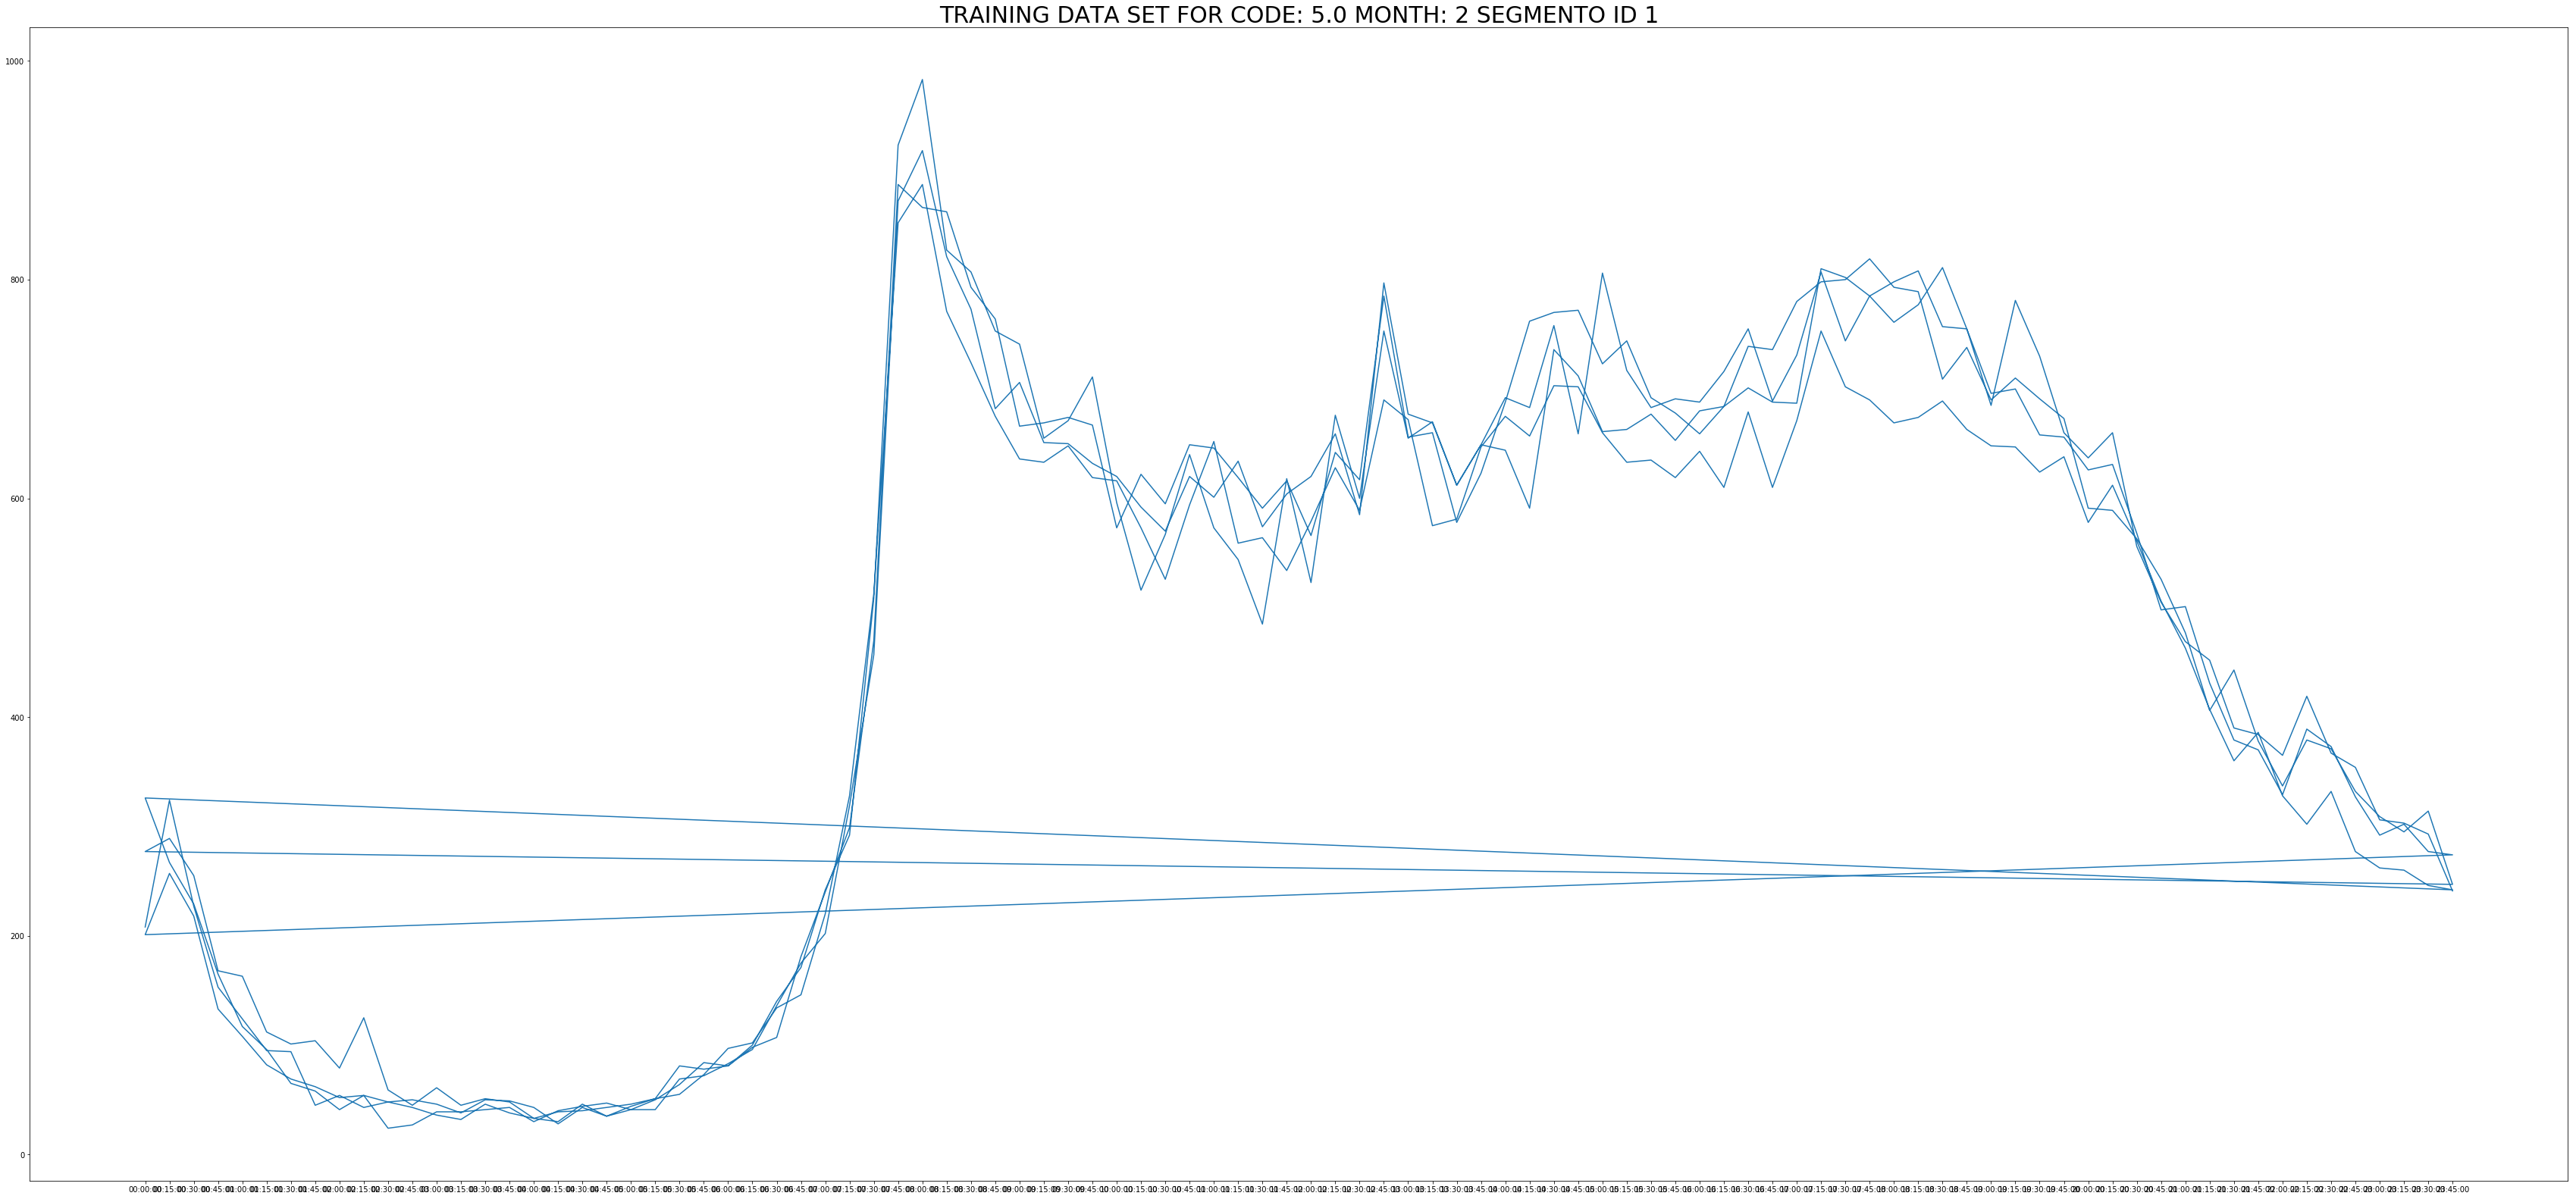

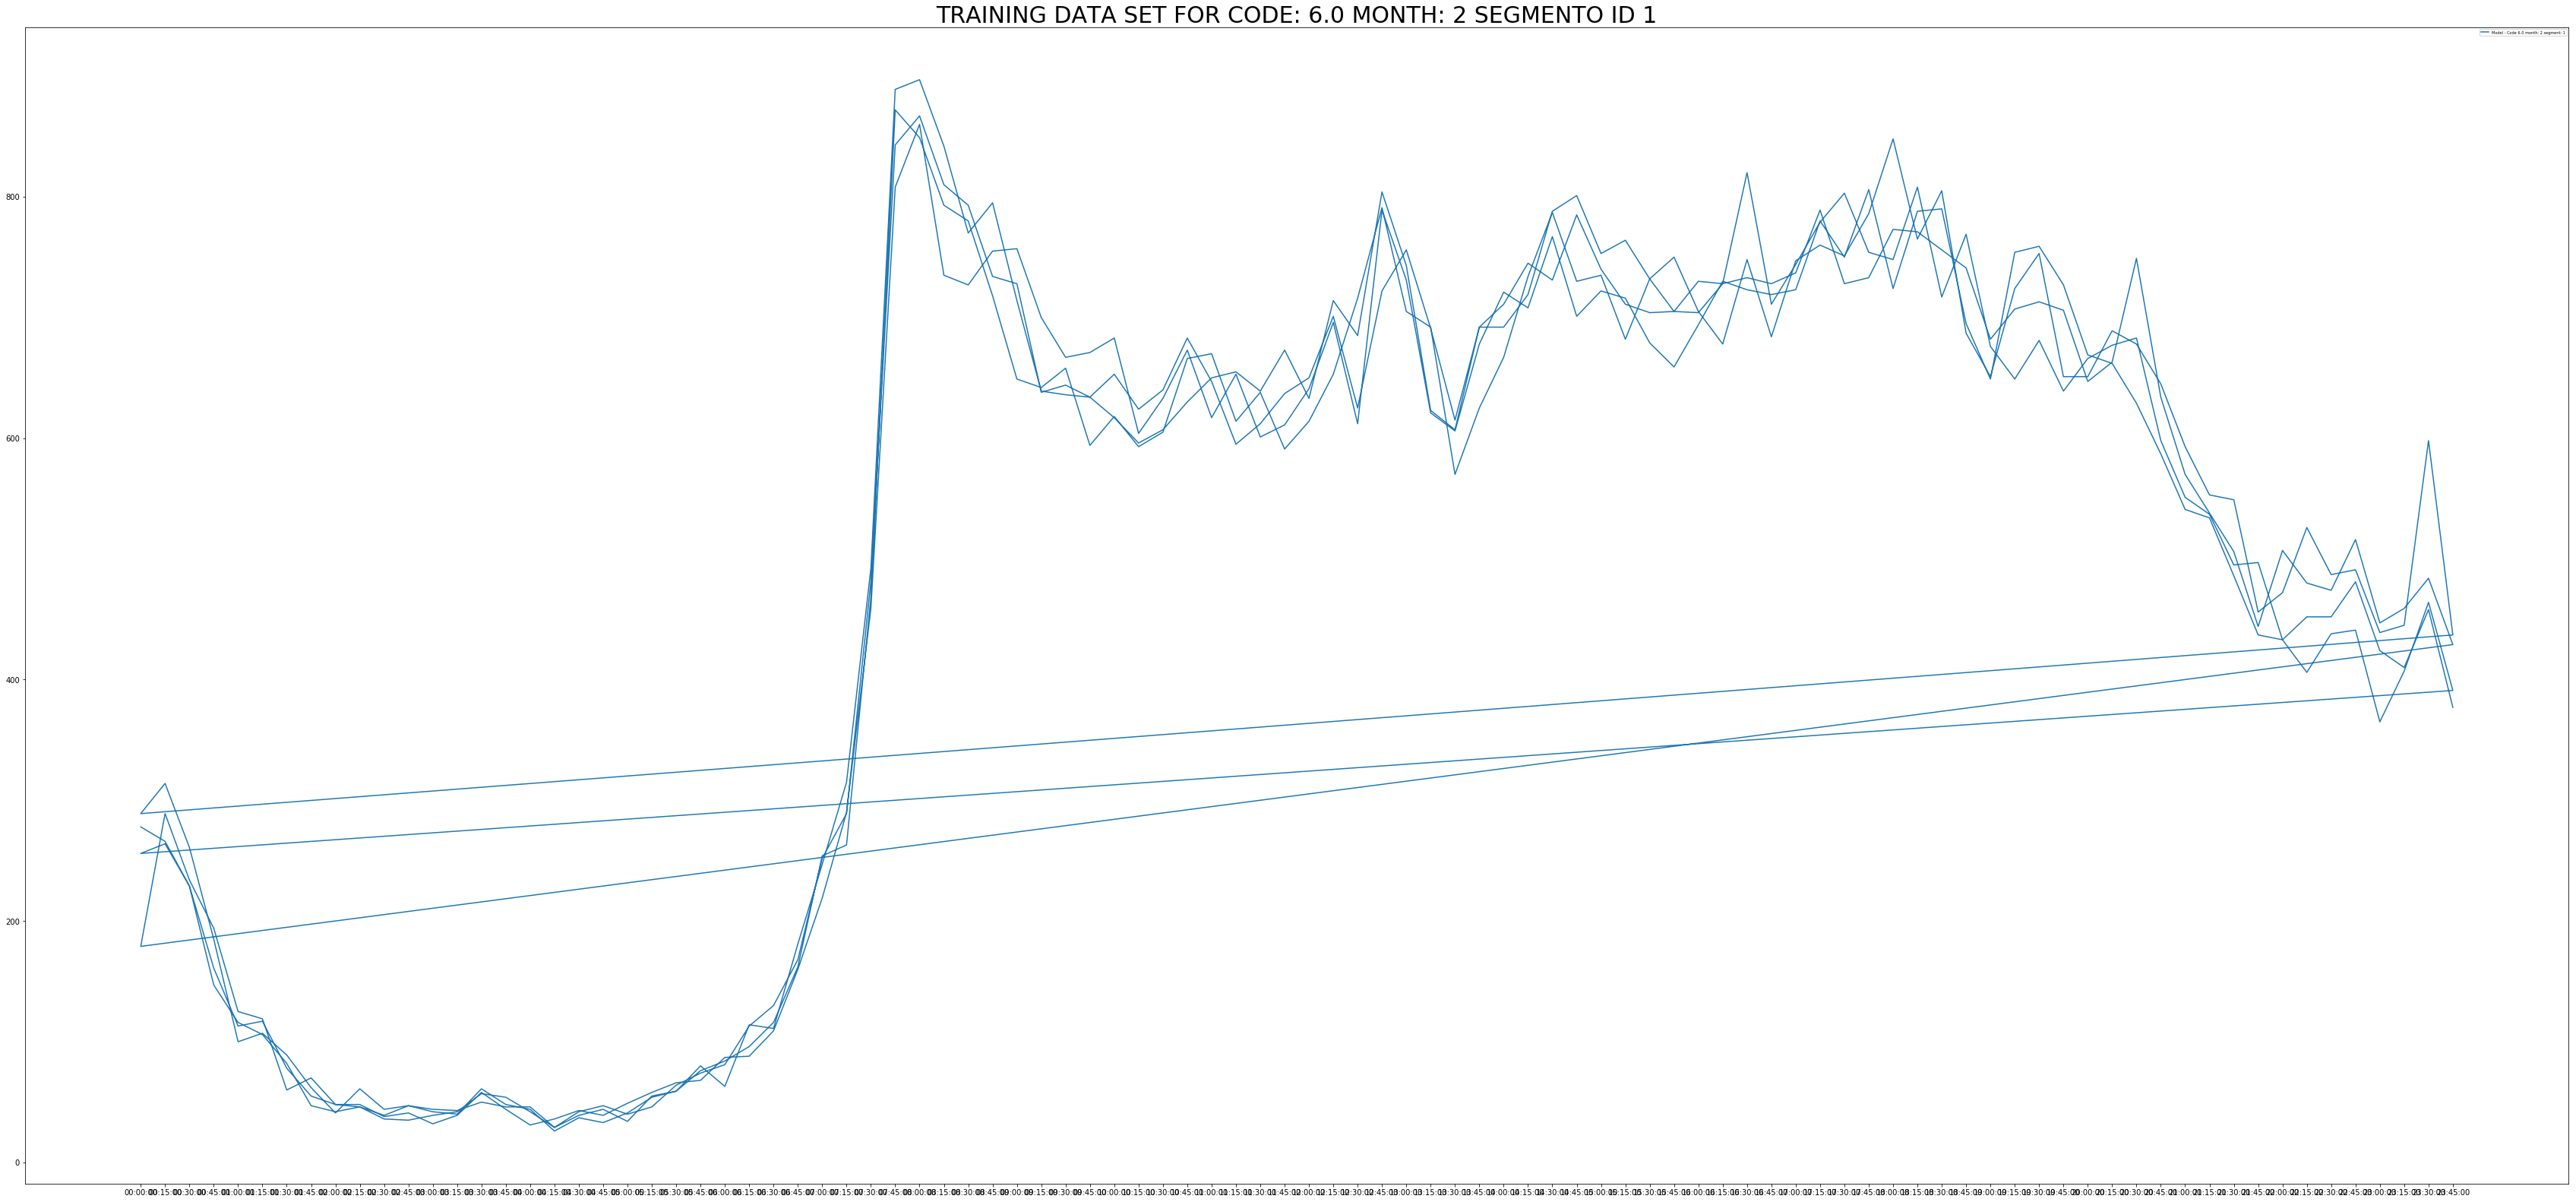

In [23]:
months=[1,2]
segments=[1]
import matplotlib.pyplot as plt

for month_i in months: # Months 1 y 2
    for seg_id in segments: # Segment 1
        for code_i in df_month_seg.COD_LABORALIDAD.unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)&(df_training_sets.COD_LABORALIDAD==code_i)]['TRAINING_SET'].iloc[0]
            # Plot training days
            plt.figure(figsize=(60,28))
            plt.title('TRAINING DATA SET FOR CODE: ' + str(code_i) + ' MONTH: ' + str(month_i) + ' SEGMENTO ID ' + str(seg_id) ,  fontsize=30)
            plt.plot(df_train.index, df_train.TOTAL_VEHICULOS, marker='', label=str("Model - Code " + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id)))

plt.legend(loc='best',  fontsize=5)
plt.show()

### EXPONENTIAL SMOOTHING

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing

In [81]:
months=[1,2]
segments=[1]
import matplotlib.pyplot as plt
import numpy as np

for seg_id in segments: # Segment 1
    for month_i in months: # Months 1 y 2
        for code_i in df_training_sets['COD_LABORALIDAD'].unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)&(df_training_sets.COD_LABORALIDAD==code_i)]['TRAINING_SET'].iloc[0]
            index_values = df_train.iloc[0].index
    
            # Train arima models
            #training_values = df_train.TOTAL_VEHICULOS
            #exp_fit1 = ExponentialSmoothing(np.asarray(training_values), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5)
            #y_hat_avg = exp_fit1.forecast(steps=len(index_values))
            print("code " + str(code_i) + str(len(index_values)))
             # plt.figure(figsize=(40,18))
            print('Exponential Smoothing - Model :  Code ' + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id))
 # plt.legend(loc='best')
 # plt.show()

code 2.032
Exponential Smoothing - Model :  Code 2.0 month: 1 segment: 1
code 1.032
Exponential Smoothing - Model :  Code 1.0 month: 1 segment: 1
code 3.032
Exponential Smoothing - Model :  Code 3.0 month: 1 segment: 1
code 4.032
Exponential Smoothing - Model :  Code 4.0 month: 1 segment: 1
code 5.032
Exponential Smoothing - Model :  Code 5.0 month: 1 segment: 1
code 6.032
Exponential Smoothing - Model :  Code 6.0 month: 1 segment: 1
code 7.032
Exponential Smoothing - Model :  Code 7.0 month: 1 segment: 1
code 2.032
Exponential Smoothing - Model :  Code 2.0 month: 2 segment: 1
code 1.032
Exponential Smoothing - Model :  Code 1.0 month: 2 segment: 1
code 3.032
Exponential Smoothing - Model :  Code 3.0 month: 2 segment: 1
code 4.032
Exponential Smoothing - Model :  Code 4.0 month: 2 segment: 1
code 5.032
Exponential Smoothing - Model :  Code 5.0 month: 2 segment: 1
code 6.032
Exponential Smoothing - Model :  Code 6.0 month: 2 segment: 1
code 7.032
Exponential Smoothing - Model :  Code 7.

### Generate model_data.csv with the generalized curve extracted with each model

Estructura de model_data.csv

- MODELO: Modelo con el que se ha calculado la curva patron REF_ARIMA .... X (Model)
- ID_SEGMENT: Segmento id para el que se ha calculado el modelo
- MES: Mes para el que se ha calculado el modelo
- COD_LABORALIDAD: Codigo de laboralidad para el cual se ha calculado el modelo
- TIME: El timestamp con formato HH:MM:SS (diario)
- TOTAL_VEHICULOS: Valor asociado a un time dentro del dia patron con cod_laboralidad X, segmento Y, mes Z


In [70]:
exp_model_data_dict = {'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD': [], 'TIME':[], 'TOTAL_VEHICULOS': []}

In [71]:
import matplotlib.pyplot as plt
import numpy as np
MODEL_NAME =  'ExponentialSmoothing'

segments=[1]
months=[1]
codes=[1]

for seg_id in segments:#df_training_sets['ID_SEGMENT'].unique()[0:2]: # Segment
    index_values=None
    training_values=None
    y_hat_avg=None
    exp_fit1=None
    df_train=None
    for month_i in months:#df_training_sets['MES'].unique(): # Months 
        for code_i in codes:#df_training_sets['COD_LABORALIDAD'].unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==int(month_i))&(df_training_sets.ID_SEGMENT==int(seg_id))&(df_training_sets.COD_LABORALIDAD==int(code_i))]['TRAINING_SET'].iloc[0]
            index_values = df_train.index
            # Train exponential smoothing models
            training_values = df_train.TOTAL_VEHICULOS
            exp_fit1 = ExponentialSmoothing(np.asarray(training_values), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5)
            y_hat_avg = exp_fit1.forecast(steps=len(index_values))
            
            # Fill model_data_dict with the model curve
            exp_model_data_dict['ID_SEGMENT'].extend([int(seg_id)]*len(index_values))
            exp_model_data_dict['MES'].extend([int(month_i)]*len(index_values))
            exp_model_data_dict['COD_LABORALIDAD'].extend([int(code_i)]*len(index_values))
            exp_model_data_dict['TIME'].extend(index_values)
            exp_model_data_dict['TOTAL_VEHICULOS'].extend(y_hat_avg.astype(int))

In [72]:
df_exp_model = None
df_exp_model = pd.DataFrame(exp_model_data_dict)
df_exp_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 5 columns):
ID_SEGMENT         384 non-null int64
MES                384 non-null int64
COD_LABORALIDAD    384 non-null int64
TIME               384 non-null object
TOTAL_VEHICULOS    384 non-null int64
dtypes: int64(4), object(1)
memory usage: 15.1+ KB


In [73]:
df_exp_model.to_csv("ExponentialSmoothing_seg1_m1_2.csv", index=False)

### Check white noise signal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

arima_model_data_dict = {'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD': [], 'TIME':[], 'TOTAL_VEHICULOS': []}

MODEL_NAME =  'ARIMA'
df_avg_totalVehicles = df_exp_model.groupBy(['ID_SEGMENT','MES','COD_LABORALIDAD']).avg('TOTAL_VEHICULOS')

for seg_id in df_exp_model['ID_SEGMENT'].unique(): # Segment
    for month_i in df_exp_model['MES'].unique(): # Months 
        for code_i in df_exp_model['COD_LABORALIDAD'].unique(): # All codes present
            mean = df_avg_totalVehicles.loc[(df_avg_totalVehicles.MES==month_i)&(df_avg_totalVehicles.ID_SEGMENT==seg_id)&(df_avg_totalVehicles.COD_LABORALIDAD==code_i)]['avg(TOTAL_VEHICULOS)'].iloc[0]
            noise = np.random.poisson(target_dims)
            df_train = df_exp_model.loc[(df_exp_model.MES==month_i)&(df_exp_model.ID_SEGMENT==seg_id)&(df_exp_model.COD_LABORALIDAD==code_i)]
            index_values = df_train.TIME
            noise = np.random.poisson(mean, len(index_values))
            preds = df_train.TOTAL_VEHICULOS + noise
            
            # Fill model_data_dict with the model curve
            arima_model_data_dict['ID_SEGMENT'].extend([int(seg_id)]*len(index_values))
            arima_model_data_dict['MES'].extend([int(month_i)]*len(index_values))
            arima_model_data_dict['COD_LABORALIDAD'].extend([int(code_i)]*len(index_values))
            arima_model_data_dict['TIME'].extend(index_values)
            arima_model_data_dict['TOTAL_VEHICULOS'].extend(preds.astype(int))

In [ ]:
df_arima_model = pd.DataFrame(arima_model_data_dict)
df_arima_model.info()

In [ ]:
df_arima_model.to_csv("Arima.csv", index=False)

In [ ]:
### Model Evaluation - Plot testing and model

In [ ]:
preds_ar = df_arima_model.loc[(df_arima_model.MES==1)&(df_arima_model.ID_SEGMENT==1)&(df_arima_model.COD_LABORALIDAD==1)]['TOTAL_VEHICULOS']
preds_exp = df_exp_model.loc[(df_exp_model.MES==1)&(df_exp_model.ID_SEGMENT==1)&(df_exp_model.COD_LABORALIDAD==1)]['TOTAL_VEHICULOS']
test_enero19 = df_enero19_seg1.loc[df_enero19_seg1.COD_LABORALIDAD==1]['TOTAL_VEHICULOS']
real = df_anual_data.loc[(df_anual_data.MES==1)&(df_anual_data.ID_SEGMENT==1)&(df_anual_data.COD_LABORALIDAD==1)]
index_values = df_enero19_seg1.loc[df_enero19_seg1.COD_LABORALIDAD==1].index

plt.figure(figsize=(40,18))
for i in range(real.size)
    plt.plot(index_values, real.iloc[i]['TOTAL_VEHICULOS'], label='Real')
    
plt.plot(index_values, preds_ar, label='arima')
plt.plot(index_values, preds_exp, label='exponential')
plt.plot(index_values, test_enero19, label='test')
plt.legend(loc='best')
plt.show()